### 1. Set Inital Env

In [2]:
rm(list = ls())
library(data.table)
library(magrittr)
library(ggplot2)
library(Rcpp)
library(dtw)
library(CausalImpact)
library(bsts)
library(zoo)

sourceCpp("shapeDTW_translate/dpcore.cpp")
source("dpfast.R")
source("dist2.R")
source("weightFunc.R")
source("shapeDTW_translate/shapeDTW.R")
source("shapeDTW_translate/DTWfast.R")
source("shapeDTW_translate/hist_cost_2.R")
source("shapeDTW_translate/zNormalizeTS.R")
source("shapeDTW_translate/samplingSequencesIdx.R")
source("shapeDTW_translate/calcDescriptor.R")
source("shapeDTW_translate/descriptorPAA.R")
source("shapeDTW_translate/PAA.R")
source("shapeDTW_translate/descriptorHOG1D.R")
source("shapeDTW_translate/validatePAAparam.R")
source("shapeDTW_translate/validatePAAdescriptorparam.R")
source("shapeDTW_translate/validateHOG1Dparam.R")
source("shapeDTW_translate/validateDWTdescriptorparam.R")
source("shapeDTW_translate/whichInterval.R")
source("shapeDTW_translate/wpath2mat.R")
source("shapeDTW_translate/plotElasticMatching.R")

options(repr.plot.width = 16, repr.plot.height = 5)

### 2. Load Data

In [3]:
dt <- fread("demo_HousingMarket/data_sfh.csv")
str(dt)

Classes 'data.table' and 'data.frame':	104444 obs. of  21 variables:
 $ period_begin                  : IDate, format: "2012-01-01" "2012-02-01" ...
 $ period_end                    : IDate, format: "2012-01-31" "2012-02-29" ...
 $ period_duration               : int  30 30 30 30 30 30 30 30 30 30 ...
 $ region                        : chr  "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" "Aberdeen, SD metro area" ...
 $ state_code                    : chr  "SD" "SD" "SD" "SD" ...
 $ median_sale_price             : num  64000 159300 93000 112500 116900 ...
 $ median_list_price             : num  226250 99900 143200 111900 109900 ...
 $ median_ppsf                   : num  44.6 80.6 67.3 57.2 54.6 ...
 $ median_list_ppsf              : num  66.3 54.8 71.9 61.4 62.9 ...
 $ homes_sold                    : int  3 1 3 3 6 3 6 4 6 9 ...
 $ pending_sales                 : int  1 NA 2 1 3 1 1 4 3 3 ...
 $ new_listings                  : int  2 3 14 2 3 10 4 8 8 2 .

### 3. Preprocess Data
#### 3.1 Drop Metros with Missing Data

In [4]:
# Check number of NA's
as.data.frame(colSums(is.na(dt)))

colSums(is.na(dt))
period_begin                       0             
period_end                         0             
period_duration                    0             
region                             0             
state_code                         0             
median_sale_price                102             
median_list_price               2644             
median_ppsf                      295             
median_list_ppsf                2771             
homes_sold                       102             
pending_sales                   5323             
new_listings                    2973             
inventory                       1118             
months_of_supply                 644             
median_dom                      1042             
avg_sale_to_list                3754             
sold_above_list                  136             
price_drops                    53764             
off_market_in_two_weeks         4941             
parent_metro_region                0             
parent_metro_region_metro_code     0

In [5]:
# Select metros without NAs
dt[, ':='(id_NA = max(is.na(median_sale_price)|is.na(median_ppsf)), n_month = .N), by='region']
dt_nonNA <- dt[id_NA == FALSE]

metro_list_all <- unique(dt$region)
metro_list_nonNA <- unique(dt_nonNA$region)
cat(paste0("Number of All Regions: ", length(metro_list_all),
           "\nNumber of Regions w/o NAs: ", length(metro_list_nonNA)))

Number of All Regions: 909
Number of Regions w/o NAs: 856

#### 3.2 Select Metros with Same Data Length

There 909 regions included the data, out of which 856 regions have no mising values of median sales price or median price per square footage. 530 regions have the longest length of time series data, from 2012-01-01 to 2023-04-01, ie, 136 months.

In [6]:
# Check the distribution of data length by metro
table(dt_nonNA[, .(len = unique(n_month)), by = "region"]$len)


  4   5   6   7  16  18  20  21  22  24  25  26  27  29  30  31  34  36  40  41 
  1   1   1   1   1   1   2   1   1   2   2   2   2   1   2   1   1   1   5   2 
 42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61 
  2   2   3   4   2   4   1   2   5   4   3  11   5   2   4   5   7   5   3   4 
 62  63  64  65  67  68  69  70  71  72  73  74  75  77  78  79  81  83  84  85 
  4   2   1   2   5   1   2   5   4   1   4   5   3   3   1   2   2   2   2   3 
 86  87  89  90  91  92  94  95  96  97  98  99 100 102 103 104 105 106 107 108 
  3   1   1   2   2   1   1   3   7   2   4   4   3  14   4   3   1   3   4   3 
111 112 113 114 115 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 
  3   1   1   2   3   3   1   3   2   2  12   2   2   1   2   2   3   7   4   6 
133 134 135 136 
  9  13  13 530 

In [7]:
# Find metros of interest
metro_interest <- c("Austin, TX", "New York, NY", "Seattle, WA", "San Jose, CA", "Detroit, MI", "Chicago, IL")
for (m in metro_interest) {
    metro <- grep(m, metro_list_nonNA, value = TRUE)
    print(dt_nonNA[region %in% metro
                   , .(start = min(period_begin), end = max(period_begin), n_month = unique(n_month))
                   , by = "region"])
}

                  region      start        end n_month
1: Austin, TX metro area 2012-01-01 2023-04-01     136
                    region      start        end n_month
1: New York, NY metro area 2015-05-01 2023-04-01      96
                   region      start        end n_month
1: Seattle, WA metro area 2012-01-01 2023-04-01     136
                    region      start        end n_month
1: San Jose, CA metro area 2012-01-01 2023-04-01     136
                   region      start        end n_month
1: Detroit, MI metro area 2013-02-01 2023-04-01     123
                   region      start        end n_month
1: Chicago, IL metro area 2012-01-01 2023-04-01     136


In [8]:
# Select metros with the same length of data (7 years and 4 months up to April 2023)
date_initial <- as.Date("2016-01-01")
dt_sel <- dt_nonNA[period_begin >= date_initial][
    , sel := max(sum(period_begin >= date_initial) == ((2023 - year(date_initial)) * 12 + 4))
    , by = "region"][sel == 1]

# Get the list of metros
metro_list_sel <- unique(dt_sel$region)
print(paste("Number of regions is", length(metro_list_sel)))
print(paste("Number of observations is", nrow(dt_sel)))

[1] "Number of regions is 616"
[1] "Number of observations is 54208"


### 4. TD-ShapeDTW

In [9]:
# Initialization
steppattern <- matrix(c(1, 1, 2.0, 0, 1, 1.0, 1, 0, 1.0), ncol = 3, byrow = TRUE)
metrics <- c("dtw", "wdtw", "td_wdtw", "shapedtw", "td_shapedtw")

# Normalize the target variables
var_sel <- c("median_sale_price", "median_ppsf")
dt_sel[, (paste0(var_sel, "_normalized")) := lapply(.SD, zNormalizeTS)
       , .SDcols = var_sel, by = "region"]

calMetroDist <- function(metro_name){
  
  # Results initialization
  metro_t_dist <- dt_sel[, .(dtw = 0, wdtw = 0, td_wdtw = 0, shapedtw = 0, td_shapedtw = 0), by = "region"]
  metro_t_dist_results <- list()

  # Treatment metro sequence, ie, query sequence
  metro_t <- grep(metro_name, metro_list_sel, value = TRUE)
  seq_q <- as.matrix(dt_sel[region == metro_t]$median_sale_price_normalized, ncol = 1)
   
  # Loop through all regions and calculate varying distances
  tik <- Sys.time()
  for (m in metro_list_sel) {

    # Reference sequences
    seq_ref <- as.matrix(dt_sel[region == m]$median_sale_price_normalized, ncol = 1)
    
    # DTW
    dist_DTW <- dist2(x = seq_q, c = seq_ref)
    align_DTW <- dpfast(dist_DTW, C = steppattern)
    # WDTW
    dist_WDTW <- dist2(x = seq_q, c = seq_ref, wt_func = weight_fcn)
    align_WDTW <- dpfast(dist_WDTW, C = steppattern)
    # TD-WDTW
    dist_td_WDTW <- dist2(x = seq_q, c = seq_ref, wt_func = weight_fcn_prod)
    align_td_WDTW <- dpfast(dist_td_WDTW, C = steppattern)
    # ShapeDTW
    align_shapeDTW <- shapeDTW(c(seq_q), c(seq_ref), seqlen = 5)
    # TD-ShapeDTW
    align_td_shapeDTW <- shapeDTW(c(seq_q), c(seq_ref), seqlen = 5, wt_func = weight_fcn_prod) ### ???
    
    metro_t_dist_results[m] <- list(list("align_DTW" = align_DTW,
                                         "align_WDTW" = align_WDTW,
                                         "align_td_WDTW" = align_td_WDTW,
                                         "align_shapeDTW" = align_shapeDTW,
                                         "align_td_shapeDTW" = align_td_shapeDTW))
    
    metro_t_dist[region==m, ":="(dtw = sum(align_DTW$sc),
                                 wdtw = sum(align_WDTW$sc),
                                 td_wdtw = sum(align_td_WDTW$sc),
                                 shapedtw = align_shapeDTW$distDescriptor,
                                 td_shapedtw = align_td_shapeDTW$distDescriptor)]
  }
  tok <- Sys.time()
  print(round(tok-tik, 2))
  
  metro_t_dist[, (paste0(metrics, "_rank")) := lapply(.SD, function(x) frank(x, ties.method = "min"))
               , .SDcols=metrics]
               
  return(list("metro_t_dist" = metro_t_dist,
              "metro_t_dist_results" = metro_t_dist_results))
}

In [10]:
#metro_treatment <- "Seattle, WA metro area" 
metro_treatment <- "Chicago, IL metro area" 
output <- calMetroDist(metro_name = metro_treatment)
metro_t_dist <- output$metro_t_dist
metro_t_dist_results <- output$metro_t_dist_results

Time difference of 40.61 secs


In [11]:
head(metro_t_dist[order(td_shapedtw_rank)], 20)

region                           dtw      wdtw      td_wdtw  shapedtw
1  Chicago, IL metro area            0.00000 0.0000000 0.000000   0.0000
2  Boston, MA metro area            16.31464 0.2151911 1.124905 218.3541
3  Baltimore, MD metro area         15.60304 0.2005583 1.180083 227.4127
4  Washington, DC metro area        16.27715 0.2098587 1.161966 231.4267
5  Rochester, NY metro area         16.10747 0.2167853 1.192449 225.6278
6  Kansas City, MO metro area       18.08339 0.2407315 1.361345 239.1255
7  Warren, MI metro area            15.53824 0.2041601 1.100090 238.5104
8  Seattle, WA metro area           20.87516 0.2800060 1.491576 255.8479
9  Minneapolis, MN metro area       18.90218 0.2479513 1.381312 244.5547
10 Hartford, CT metro area          17.93247 0.2381153 1.285228 244.2709
11 Columbus, OH metro area          19.26185 0.2560416 1.446712 258.6748
12 Virginia Beach, VA metro area    15.94215 0.2072068 1.191859 254.4207
13 Louisville, KY metro area        17.41417 0.2336035 1.383960 245.1830
14 Birmingham, AL metro area        15.74662 0.2088512 1.161876 250.4948
15 St. Louis, MO metro area         16.42984 0.2142702 1.229293 254.2773
16 New York, NY metro area          15.96130 0.2213104 1.218571 248.1291
17 Grand Rapids, MI metro area      21.53029 0.2848145 1.535985 266.0560
18 Frederick, MD metro area         18.28754 0.2431592 1.346361 258.6242
19 Worcester, MA metro area         18.82049 0.2610788 1.502674 251.6169
20 Montgomery County, PA metro area 16.87337 0.2280436 1.247573 253.3796
   td_shapedtw dtw_rank wdtw_rank td_wdtw_rank shapedtw_rank td_shapedtw_rank
1   0.00000     1        1         1            1             1              
2  15.89537    14       11         3            2             2              
3  16.04367     5        2         7            4             3              
4  16.46565    12        9         5            5             4              
5  16.51266    10       12        10            3             5              
6  16.56860    23       23        21            7             6              
7  17.16654     4        4         2            6             7              
8  17.22581    58       50        38           17             8              
9  17.42494    29       27        23            9             9              
10 17.43165    19       20        19            8            10              
11 17.73379    35       30        33           20            11              
12 18.06147     7        7         9           16            12              
13 18.06752    18       18        24           10            13              
14 18.16393     6        8         4           12            14              
15 18.47500    15       10        15           15            15              
16 18.47873     8       14        14           11            16              
17 18.47975    73       55        45           25            17              
18 18.50103    26       24        20           19            18              
19 18.66398    28       33        40           13            19              
20 18.85799    17       17        18           14            20

In [12]:
head(metro_t_dist[order(td_wdtw_rank)], 20)

region                           dtw      wdtw      td_wdtw  shapedtw
1  Chicago, IL metro area            0.00000 0.0000000 0.000000   0.0000
2  Warren, MI metro area            15.53824 0.2041601 1.100090 238.5104
3  Boston, MA metro area            16.31464 0.2151911 1.124905 218.3541
4  Birmingham, AL metro area        15.74662 0.2088512 1.161876 250.4948
5  Washington, DC metro area        16.27715 0.2098587 1.161966 231.4267
6  Cincinnati, OH metro area        15.46193 0.2033238 1.171827 271.8355
7  Baltimore, MD metro area         15.60304 0.2005583 1.180083 227.4127
8  Lake County, IL metro area       16.03595 0.2067046 1.191349 269.6157
9  Virginia Beach, VA metro area    15.94215 0.2072068 1.191859 254.4207
10 Rochester, NY metro area         16.10747 0.2167853 1.192449 225.6278
11 Cleveland, OH metro area         15.52097 0.2048117 1.195002 258.2785
12 New Haven, CT metro area         16.79486 0.2260401 1.201831 271.6873
13 Albany, NY metro area            16.28542 0.2221474 1.213918 263.2188
14 New York, NY metro area          15.96130 0.2213104 1.218571 248.1291
15 St. Louis, MO metro area         16.42984 0.2142702 1.229293 254.2773
16 Springfield, MA metro area       16.18878 0.2195298 1.233539 280.1073
17 Newark, NJ metro area            18.06879 0.2359625 1.239112 271.2529
18 Montgomery County, PA metro area 16.87337 0.2280436 1.247573 253.3796
19 Hartford, CT metro area          17.93247 0.2381153 1.285228 244.2709
20 Frederick, MD metro area         18.28754 0.2431592 1.346361 258.6242
   td_shapedtw dtw_rank wdtw_rank td_wdtw_rank shapedtw_rank td_shapedtw_rank
1   0.00000     1        1         1            1             1              
2  17.16654     4        4         2            6             7              
3  15.89537    14       11         3            2             2              
4  18.16393     6        8         4           12            14              
5  16.46565    12        9         5            5             4              
6  19.36992     2        3         6           30            23              
7  16.04367     5        2         7            4             3              
8  19.75916     9        6         8           26            29              
9  18.06147     7        7         9           16            12              
10 16.51266    10       12        10            3             5              
11 19.33204     3        5        11           18            22              
12 20.13370    16       16        12           29            36              
13 19.45729    13       15        13           23            25              
14 18.47873     8       14        14           11            16              
15 18.47500    15       10        15           15            15              
16 21.26488    11       13        16           37            57              
17 19.76953    22       19        17           28            30              
18 18.85799    17       17        18           14            20              
19 17.43165    19       20        19            8            10              
20 18.50103    26       24        20           19            18

#### 4.1 Matching Plot

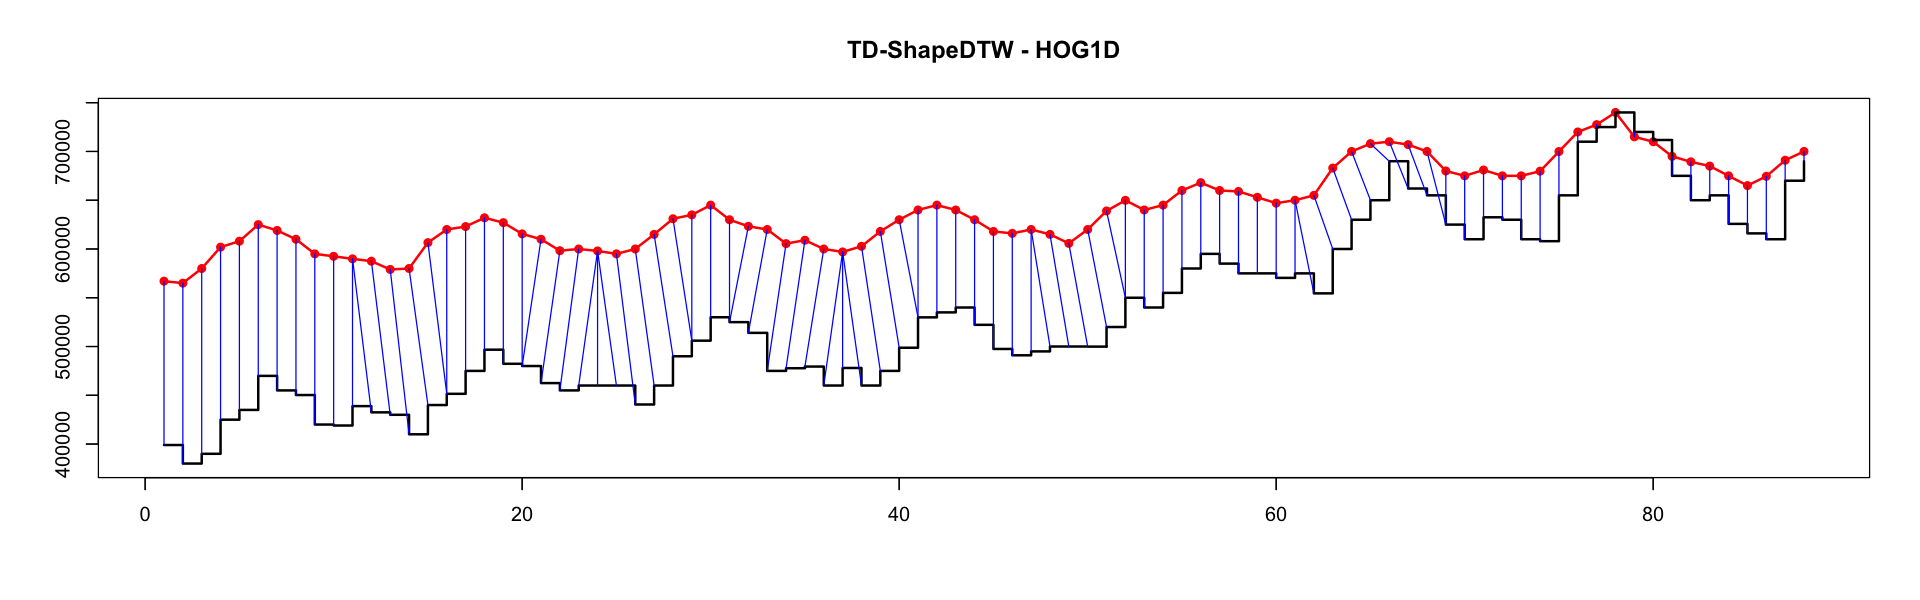

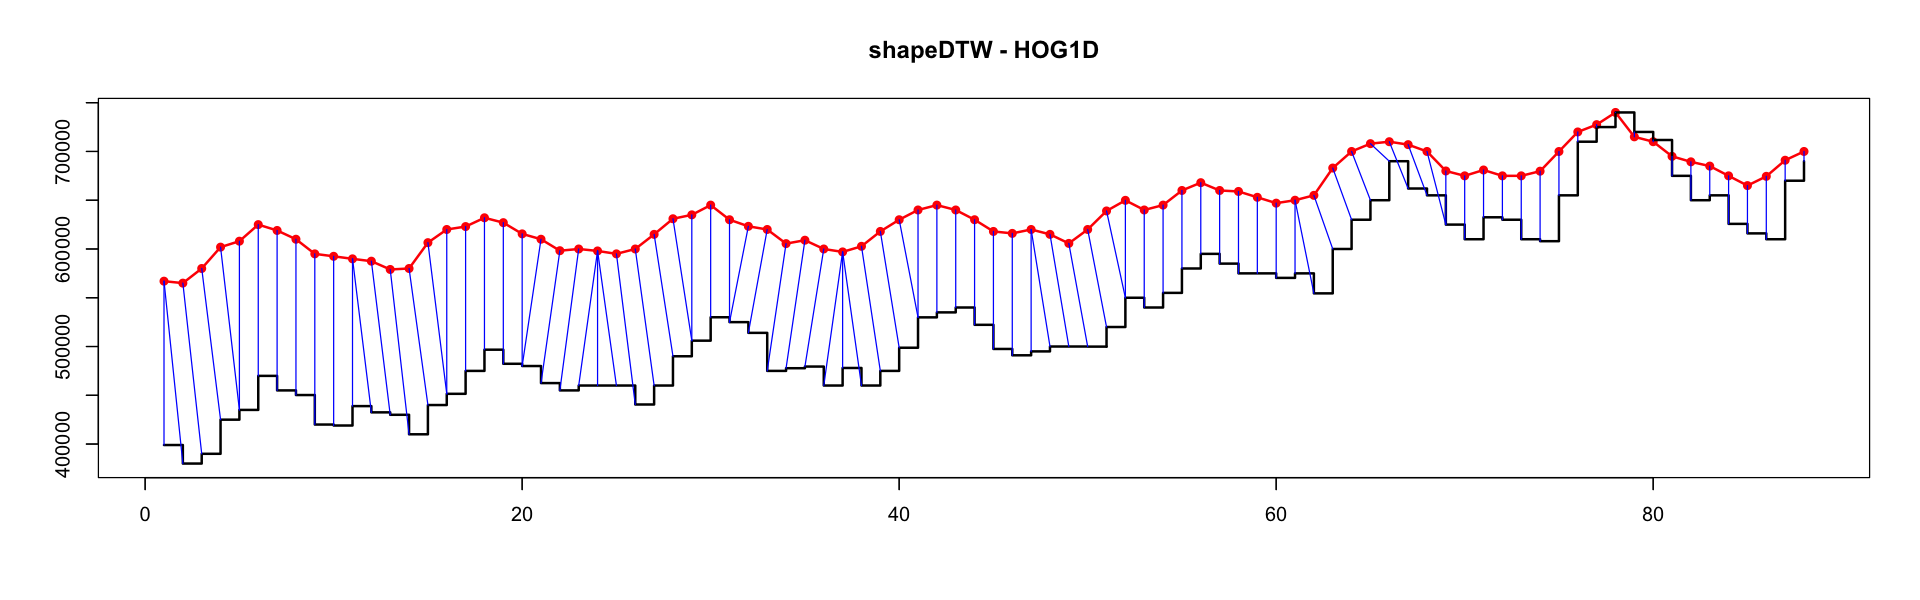

In [13]:
# Top 1 matching from TD-shapeDTW
metro_control <- metro_t_dist[order(td_shapedtw_rank)]$region[2]

# TD-shapeDTW
plotElasticMatching(dt_sel[region == metro_treatment]$median_sale_price, 
                    dt_sel[region == metro_control]$median_sale_price, 
                    metro_t_dist_results[[metro_control]]$align_td_shapeDTW$match)
title("TD-ShapeDTW - HOG1D")

# shapeDTW
plotElasticMatching(dt_sel[region == metro_treatment]$median_sale_price, 
                    dt_sel[region == metro_control]$median_sale_price, 
                    metro_t_dist_results[[metro_control]]$align_shapeDTW$match)
title("shapeDTW - HOG1D")

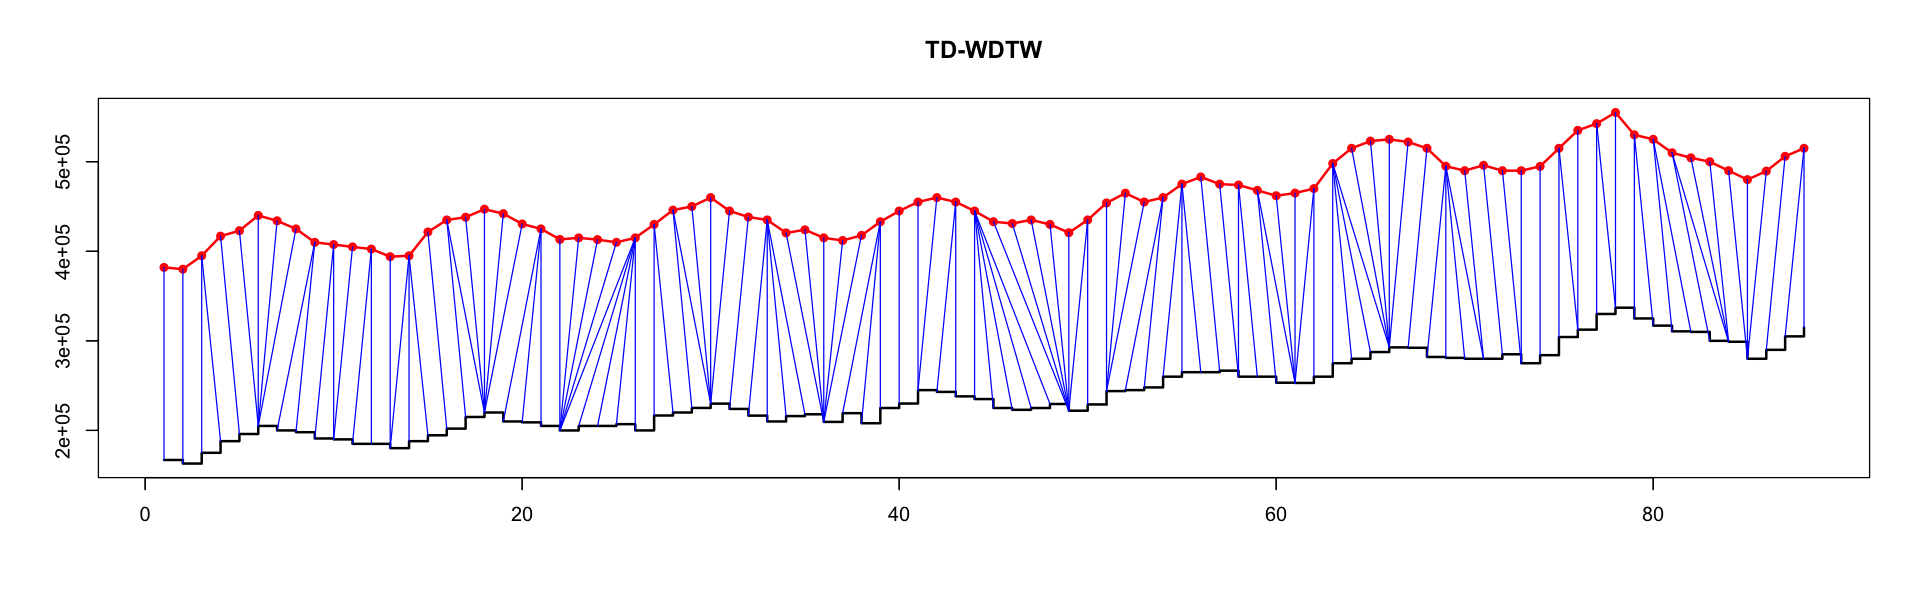

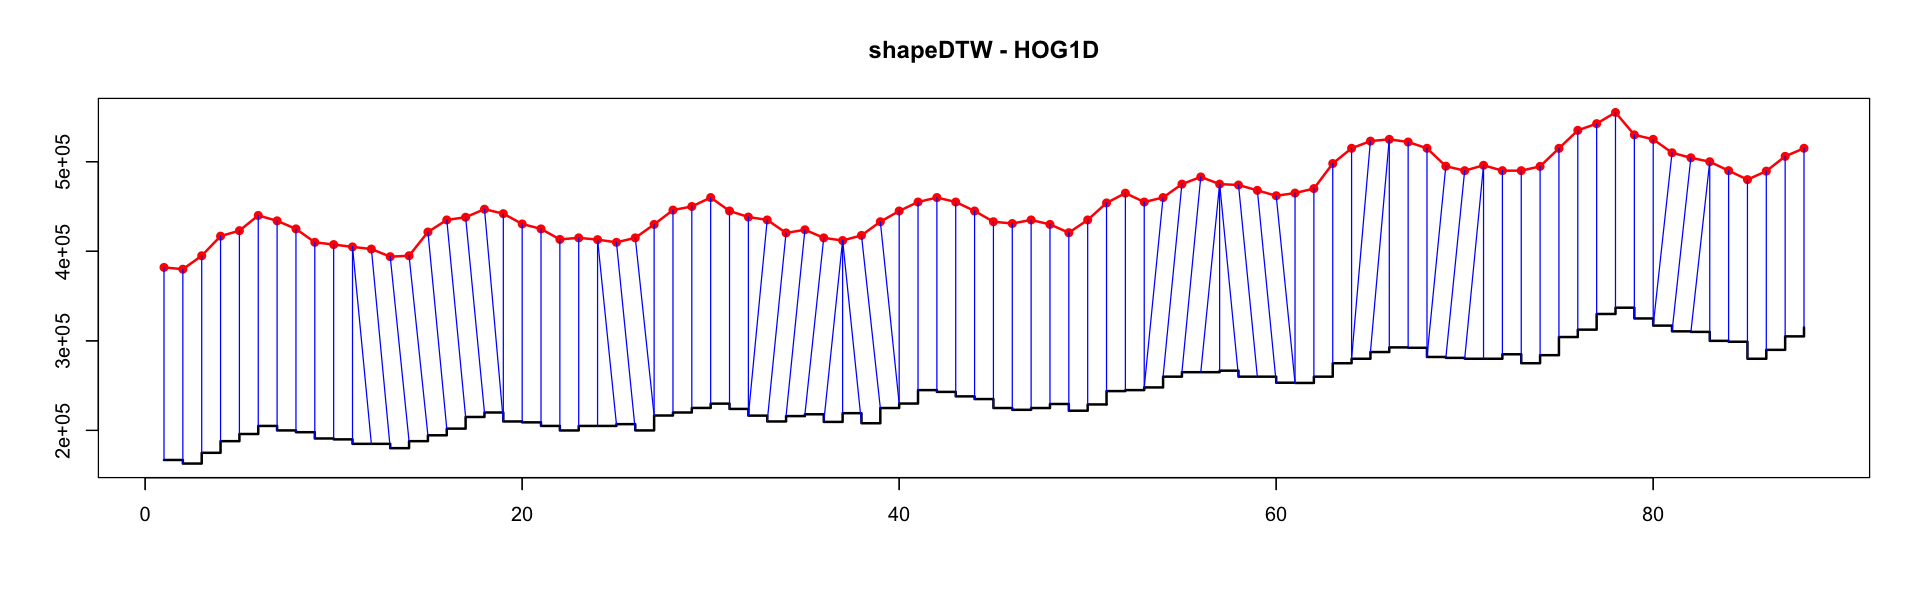

In [14]:
# Significant difference in matching between shapeDTW and TD-WDTW
metro_control <- metro_t_dist[order(td_shapedtw_rank)]$region[6]

# TD-WDTW
plotElasticMatching(dt_sel[region == metro_treatment]$median_sale_price, 
                    dt_sel[region == metro_control]$median_sale_price, 
                    cbind(metro_t_dist_results[[metro_control]]$align_td_WDTW$p, metro_t_dist_results[[metro_control]]$align_td_WDTW$q))
title("TD-WDTW")

# shapeDTW
plotElasticMatching(dt_sel[region == metro_treatment]$median_sale_price, 
                    dt_sel[region == metro_control]$median_sale_price, 
                    metro_t_dist_results[[metro_control]]$align_shapeDTW$match)
title("shapeDTW - HOG1D")

#### 4.2 Data Plot

In [15]:
plotMatchingSequences <- function(metro_set){
  ggplot(data = dt_sel[region %in% metro_set], aes(x = period_begin, y = median_sale_price, color = region)) + 
    geom_line(aes(linetype = region)) +
    geom_point() +
    scale_x_date(breaks = "3 month") + 
    theme_bw() +
    theme(
      axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
      axis.title = element_text(size = 16), axis.text = element_text(size = 16), 
      legend.title = element_text(size = 16), legend.text = element_text(size = 16),
      plot.background = element_blank(),
      panel.grid.major = element_blank()
    )
}

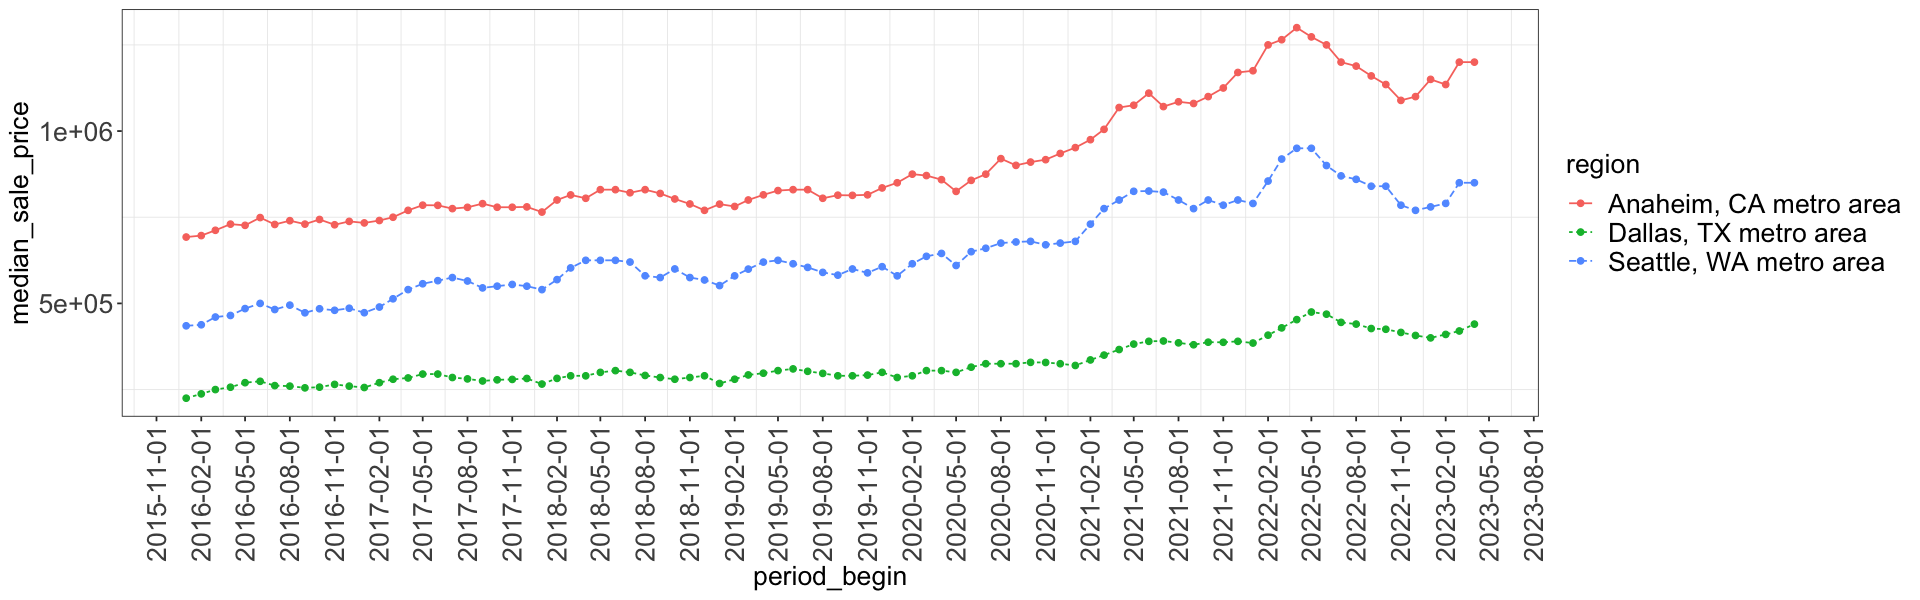

In [16]:
# Seattle
metro_t <- "Seattle, WA metro area"
metro_sel <- c(metro_t, "Dallas, TX metro area", "Anaheim, CA metro area")
plotMatchingSequences(metro_sel)


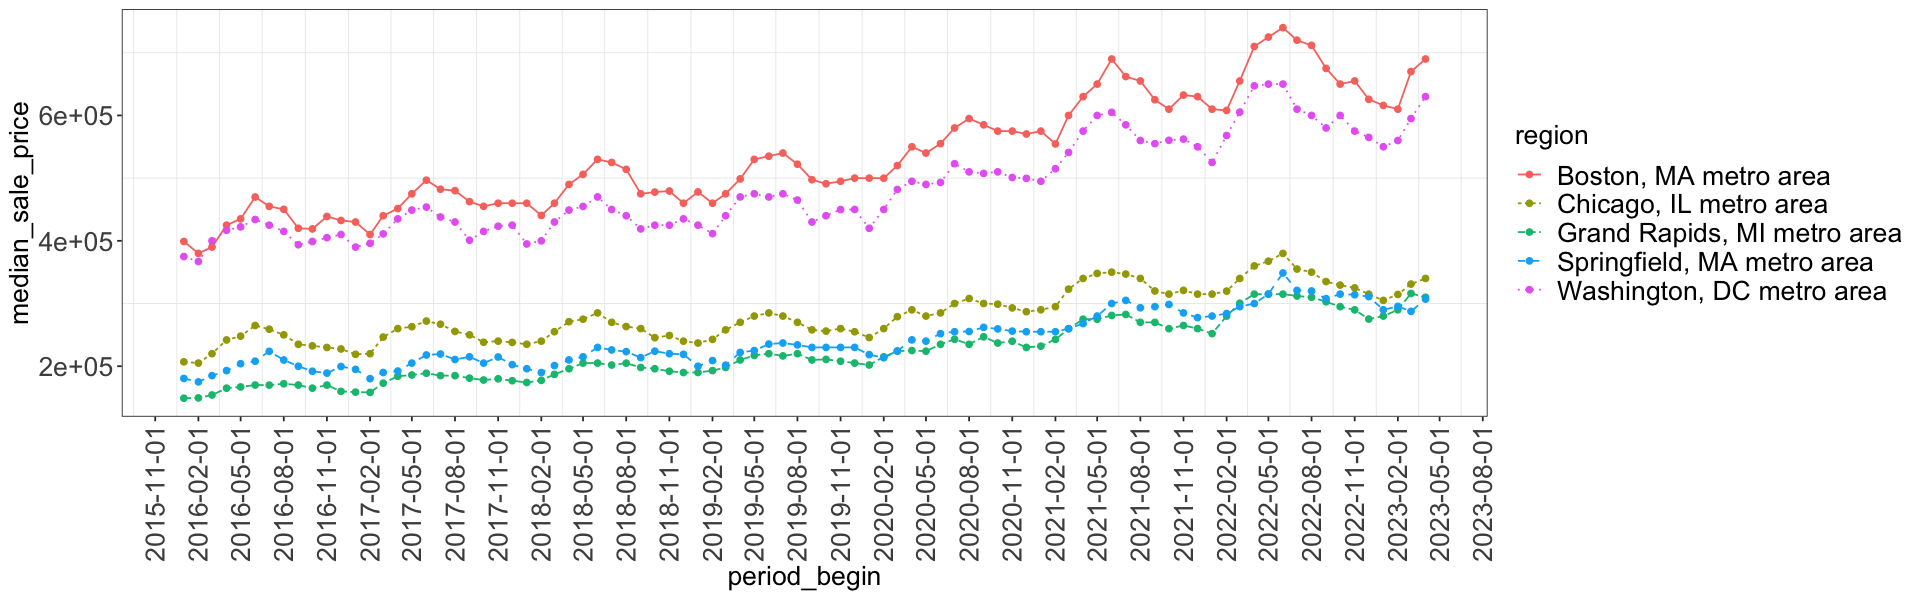

In [17]:
# Chicago
metro_t <- "Chicago, IL metro area"
metro_sel <- c(metro_t, "Boston, MA metro area", "Washington, DC metro area",  # td_shapedtw-rank2, 4
               "Grand Rapids, MI metro area", "Springfield, MA metro area") # td_shapedtw-rank6, 17, # td_wdtw-rank16
plotMatchingSequences(metro_sel)

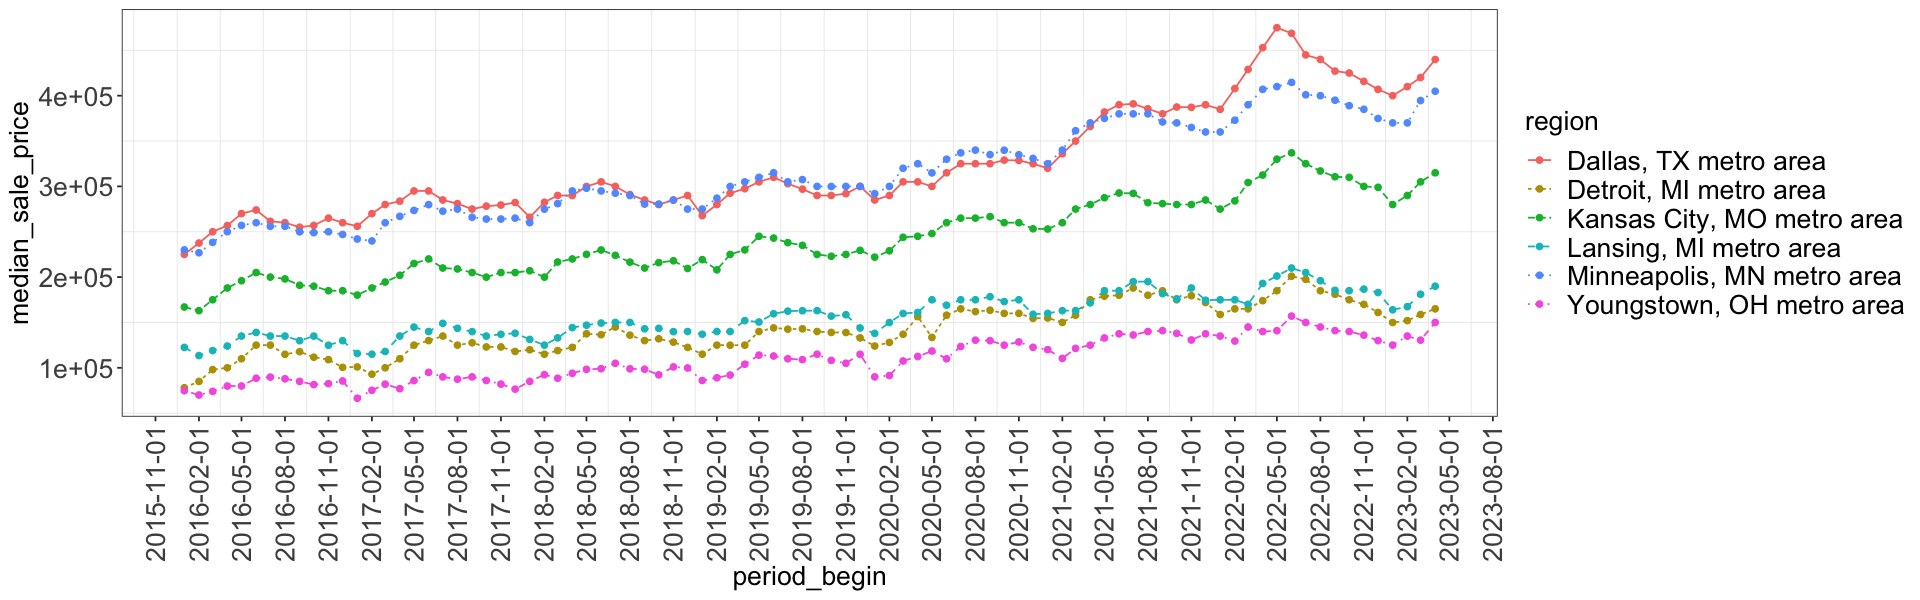

In [18]:
# Detroit
metro_t <- "Detroit, MI metro area"
metro_sel <- c(metro_t, "Kansas City, MO metro area", "Minneapolis, MN metro area", "Dallas, TX metro area", # td_shapedtw-rank4, 6, 16
               "Youngstown, OH metro area", "Lansing, MI metro area")  # td_wdtw-rank11, 19
plotMatchingSequences(metro_sel)

### 5. Causal Impact

In [19]:
# Specify test date and end date
end_date <- as.Date(max(dt_sel$period_begin))
test_date <- as.Date("2023-01-01")

# Initialization
metrics_rank <- paste0(metrics, "_rank")
month_list <- as.Date(sort(unique(dt_sel$period_begin)))

In [20]:
CausalImpactModel <- function(metro_name, alpha = 0.05, num_query = 10){
  
  # Get the distances and ranking of control metros
  output <- calMetroDist(metro_name = metro_name)
  metro_t_dist <- as.data.frame(output$metro_t_dist)
  metro_t_dist_results <- output$metro_t_dist_results

  causal_effect_results_list <- list()
  plot_results_list <- list()
  for (i in 1:length(metrics_rank)){
    
    # Get top 10 control and the treatment metro
    metric_index <- which(colnames(metro_t_dist)== metrics_rank[i])
    metro_t <- metro_t_dist[order(metro_t_dist[, metric_index]), ]$region[1]
    metro_c <- metro_t_dist[order(metro_t_dist[, metric_index]), ]$region[2:(num_query+1)]
    
    # Get the target variable: median sale price
    dt_metro_t <- dt_sel[(region == metro_t) & (period_begin <= end_date)]
    dt_metro_c_all <- dt_sel[(region %in% metro_c) & (period_begin <= end_date)]
    dt_metro_c <- dt_metro_c_all[, .(median_sale_price_c = mean(median_sale_price)), by = period_begin]
    
    # Final data used in CausalImpact
    dt_final <- as.data.frame(merge(dt_metro_t[, c("period_begin", "median_sale_price")], 
                                    dt_metro_c, 
                                    by = "period_begin"))
    dt_final <- zoo(dt_final[,2:3], month_list)
    
    # Set the observed data in the post_treatment period to NAs
    post_obs <- as.numeric(dt_final$median_sale_price[month_list >= test_date])
    dt_final$median_sale_price[month_list >= test_date] <- NA
    
    # Use BSTS package to specify custom model by adding seasonality and local linear trend
    ss <- list()
    ss <- AddSeasonal(ss, y = dt_final$median_sale_price, nseasons = 52) # Add seasonality
    ss <- AddLocalLinearTrend(ss, dt_final$median_sale_price) # Add linear trend (upward)
    bsts_model <- bsts(median_sale_price ~., state.specification = ss, data = as.data.frame(dt_final), niter = 10000, ping = 0)
    causal_impact_model <- CausalImpact(bsts.model = bsts_model, post.period.response = post_obs, alpha = alpha)
    
    # Plot the results
    options(repr.plot.width = 16, repr.plot.height = 9)
    plot_results <- plot(causal_impact_model) +
      scale_x_continuous(breaks = seq(1, length(month_list), by = 3),
                         labels = month_list[seq(1, length(month_list), by = 3)],
                         guide = guide_axis(angle = 90)) + 
      labs(title = paste0("metro_t", ": ", metrics[i]))
    print(plot_results)
    
    # Print the results
    cat(paste("# -----", metrics[i], "-----\n"))
    summary(causal_impact_model)

    # Save the output
    causal_effect_results_list[[i]] <- causal_impact_model
    plot_results_list[[i]] <- plot_results
  }
  
  return(list("metro_t_dist" = metro_t_dist,
              "metro_t_dist_results" = metro_t_dist_results,
              "causal_impact_model" = causal_effect_results_list,
              "plot_causal_impact_results" = plot_results_list))
}

#### 5.1 San Jose

Time difference of 39.04 secs
# ----- dtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1431375 (105330)     5725500 (421319)  
95% CI                   [1222712, 1637875]   [4890849, 6551498]
                                                                
Absolute effect (s.d.)   121625 (105330)      486500 (421319)   
95% CI                   [-84875, 330288]     [-339498, 1321151]
                                                                
Relative effect (s.d.)   8.5% (7.4%)          8.5% (7.4%)       
95% CI                   [-5.9%, 23%]         [-5.9%, 23%]      

Posterior tail-area probability p:   0.11885
Posterior prob. of a causal effect:  88%

For more details, type: summary(impact, "report")



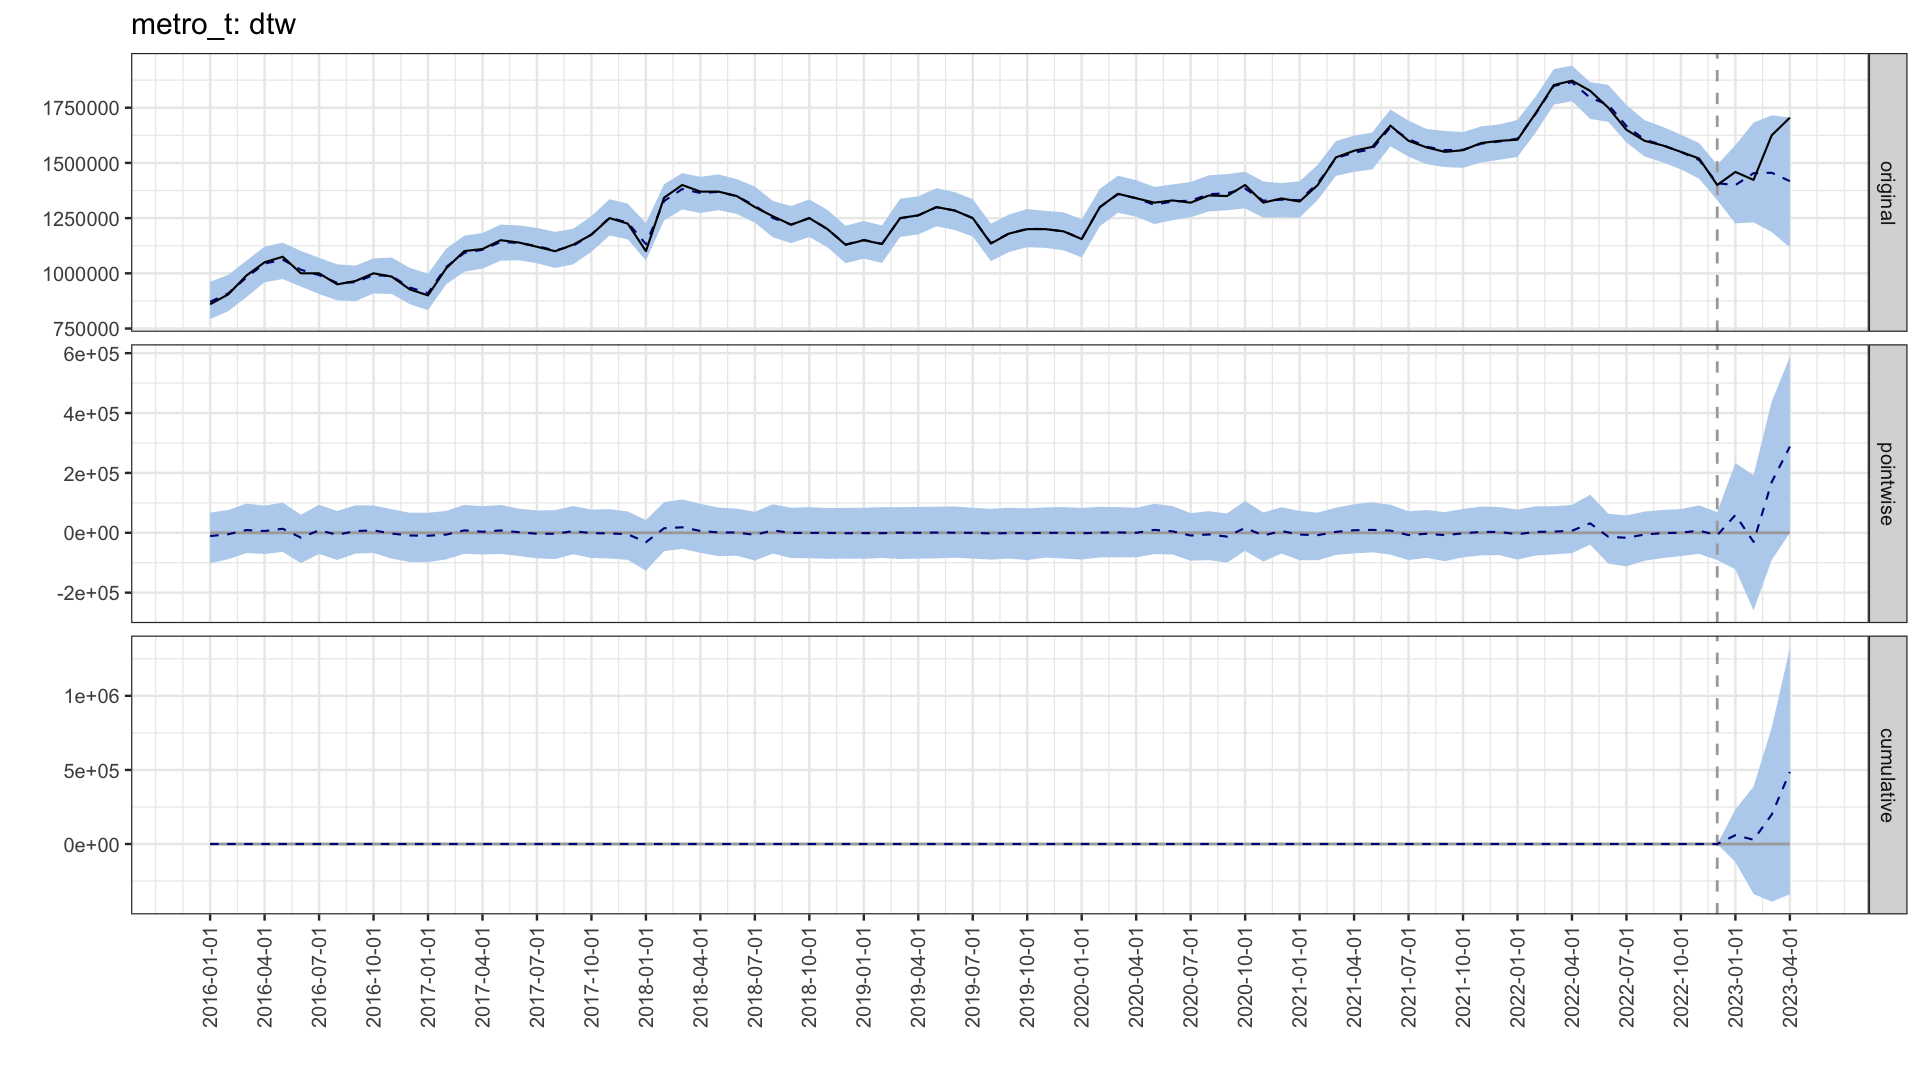

# ----- wdtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1444755 (90076)      5779021 (360303)  
95% CI                   [1260975, 1620282]   [5043901, 6481129]
                                                                
Absolute effect (s.d.)   108245 (90076)       432979 (360303)   
95% CI                   [-67282, 292025]     [-269129, 1168099]
                                                                
Relative effect (s.d.)   7.5% (6.2%)          7.5% (6.2%)       
95% CI                   [-4.7%, 20%]         [-4.7%, 20%]      

Posterior tail-area probability p:   0.10545
Posterior prob. of a causal effect:  89%

For more details, type: summary(impact, "report")



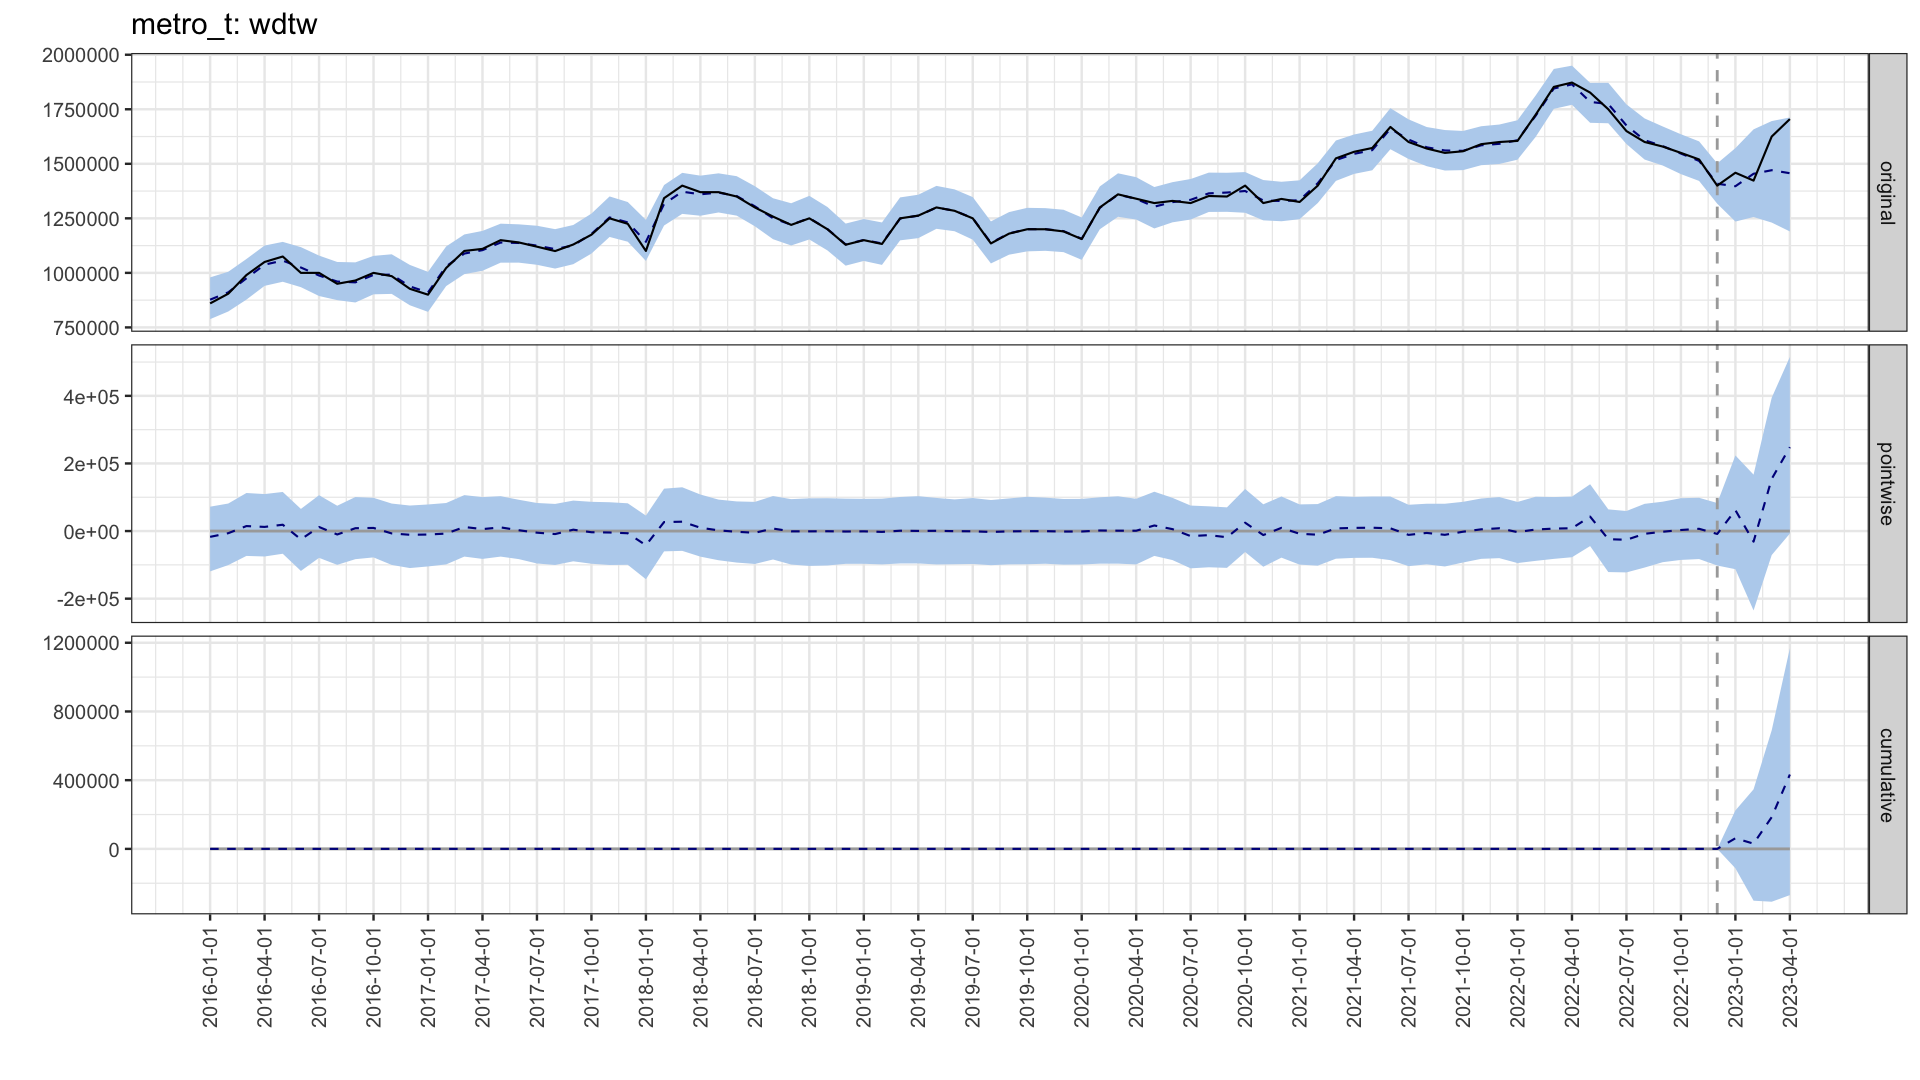

# ----- td_wdtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1437632 (96154)      5750529 (384616)  
95% CI                   [1241775, 1624936]   [4967101, 6499746]
                                                                
Absolute effect (s.d.)   115368 (96154)       461471 (384616)   
95% CI                   [-71936, 311225]     [-287746, 1244899]
                                                                
Relative effect (s.d.)   8% (6.7%)            8% (6.7%)         
95% CI                   [-5%, 22%]           [-5%, 22%]        

Posterior tail-area probability p:   0.11439
Posterior prob. of a causal effect:  89%

For more details, type: summary(impact, "report")



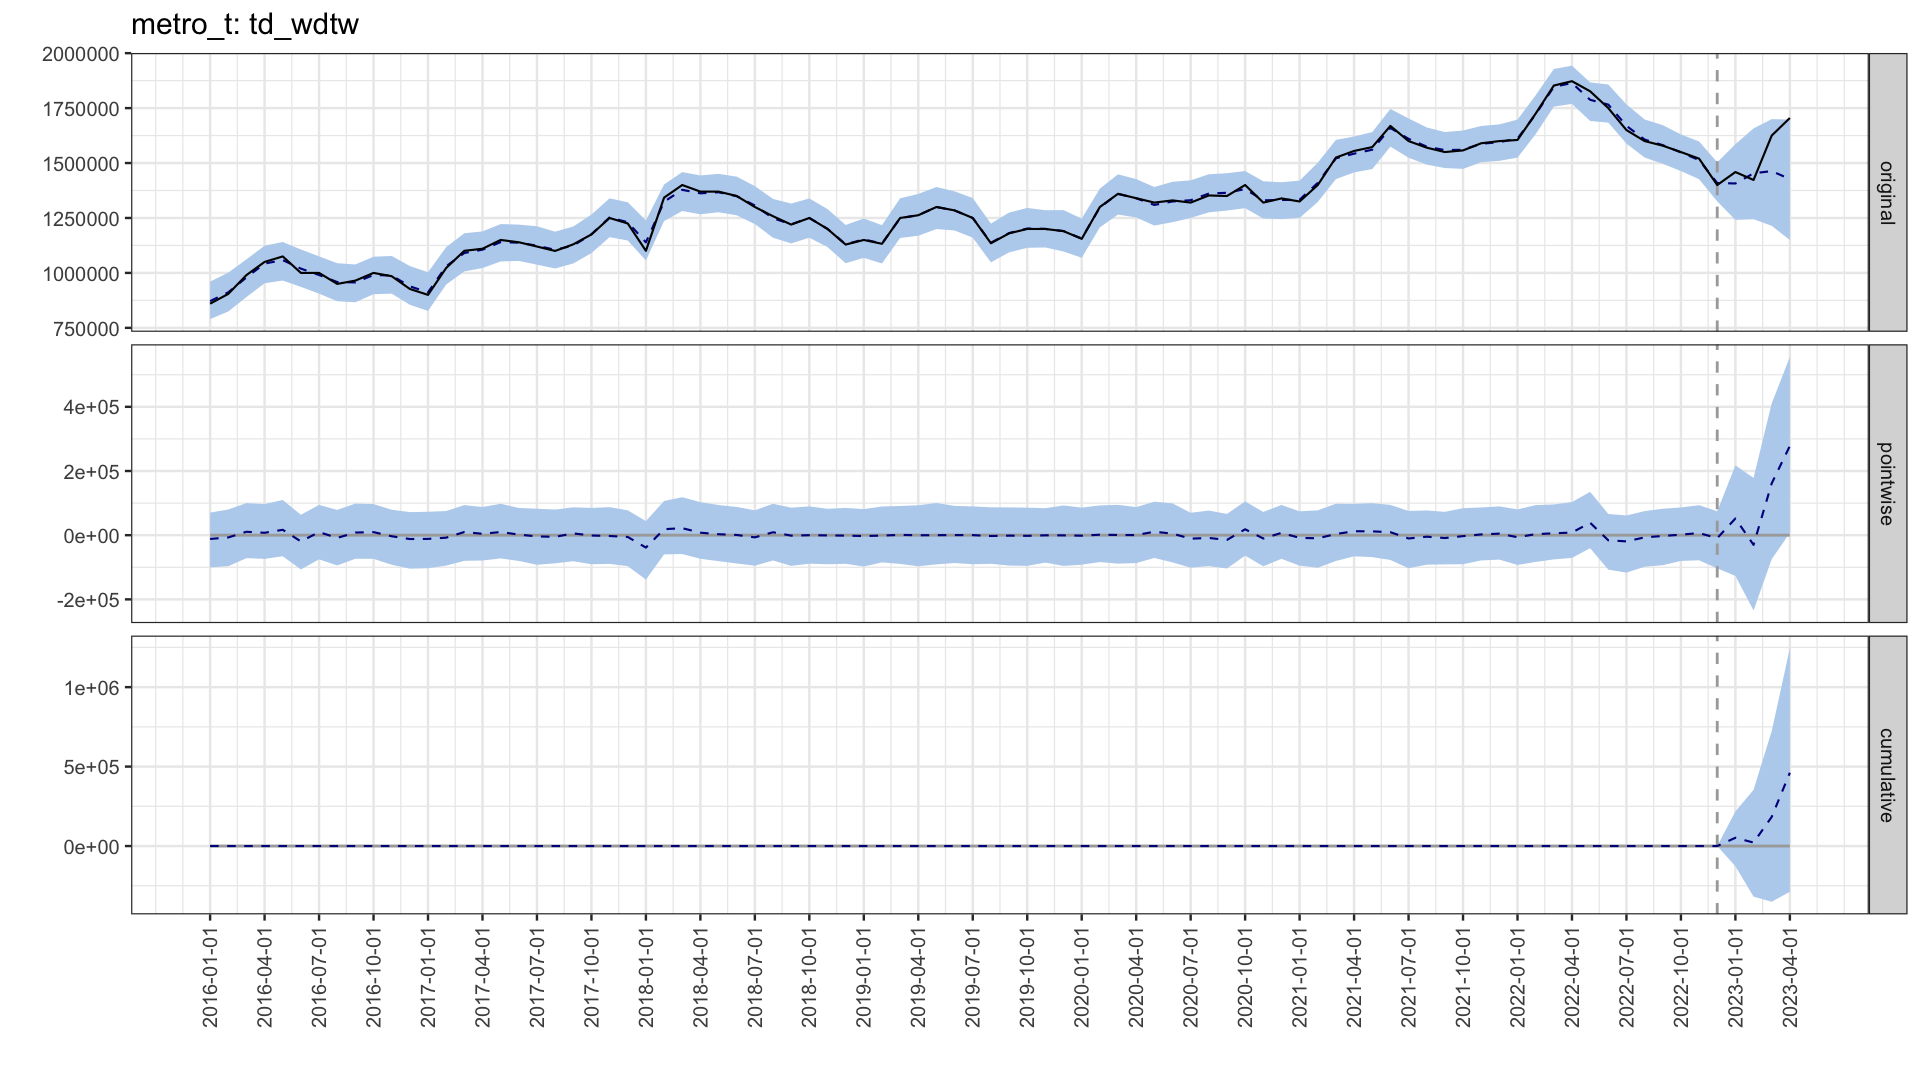

# ----- shapedtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1449073 (87919)      5796291 (351677)  
95% CI                   [1271985, 1622875]   [5087938, 6491500]
                                                                
Absolute effect (s.d.)   103927 (87919)       415709 (351677)   
95% CI                   [-69875, 281015]     [-279500, 1124062]
                                                                
Relative effect (s.d.)   7.2% (6.1%)          7.2% (6.1%)       
95% CI                   [-4.8%, 19%]         [-4.8%, 19%]      

Posterior tail-area probability p:   0.11072
Posterior prob. of a causal effect:  89%

For more details, type: summary(impact, "report")



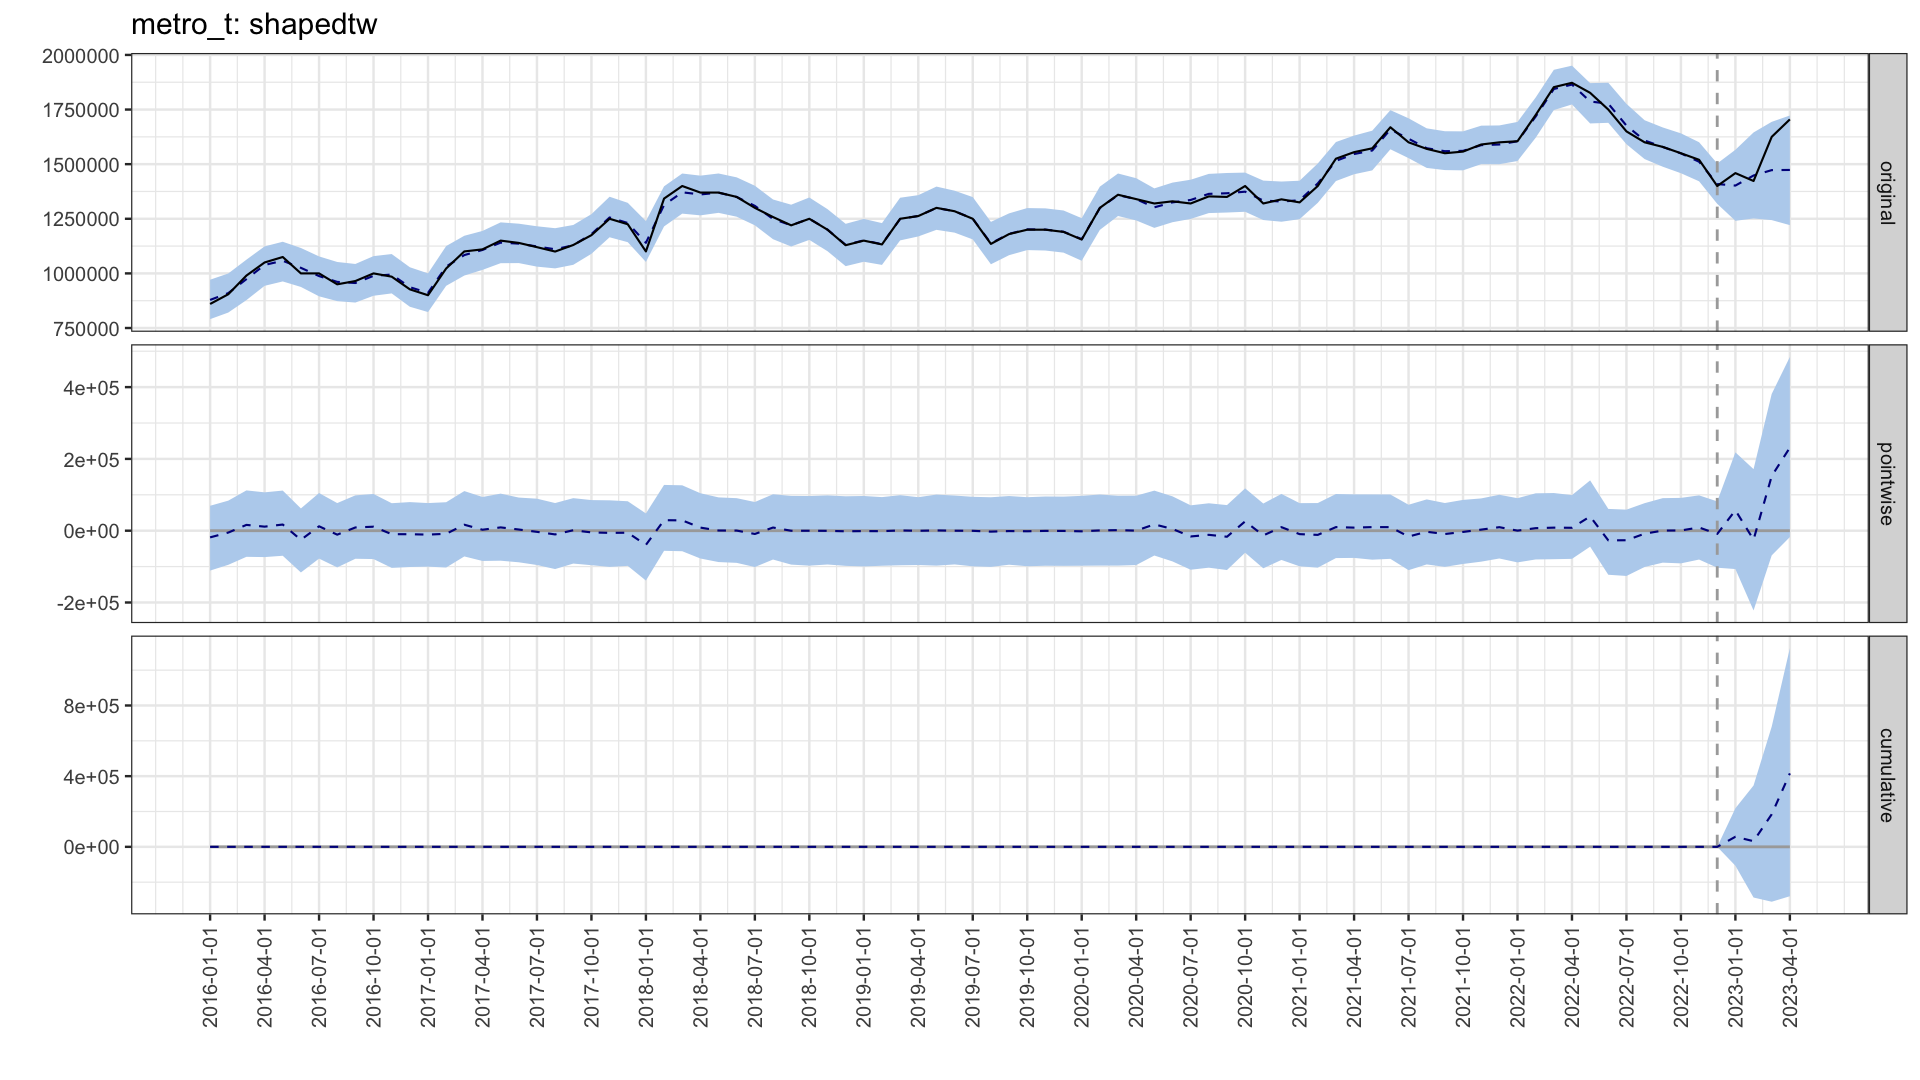

# ----- td_shapedtw -----
Posterior inference {CausalImpact}

                         Average              Cumulative        
Actual                   1553000              6212000           
Prediction (s.d.)        1439813 (99258)      5759251 (397031)  
95% CI                   [1235910, 1634655]   [4943639, 6538619]
                                                                
Absolute effect (s.d.)   113187 (99258)       452749 (397031)   
95% CI                   [-81655, 317090]     [-326619, 1268361]
                                                                
Relative effect (s.d.)   7.9% (6.9%)          7.9% (6.9%)       
95% CI                   [-5.7%, 22%]         [-5.7%, 22%]      

Posterior tail-area probability p:   0.1184
Posterior prob. of a causal effect:  88%

For more details, type: summary(impact, "report")



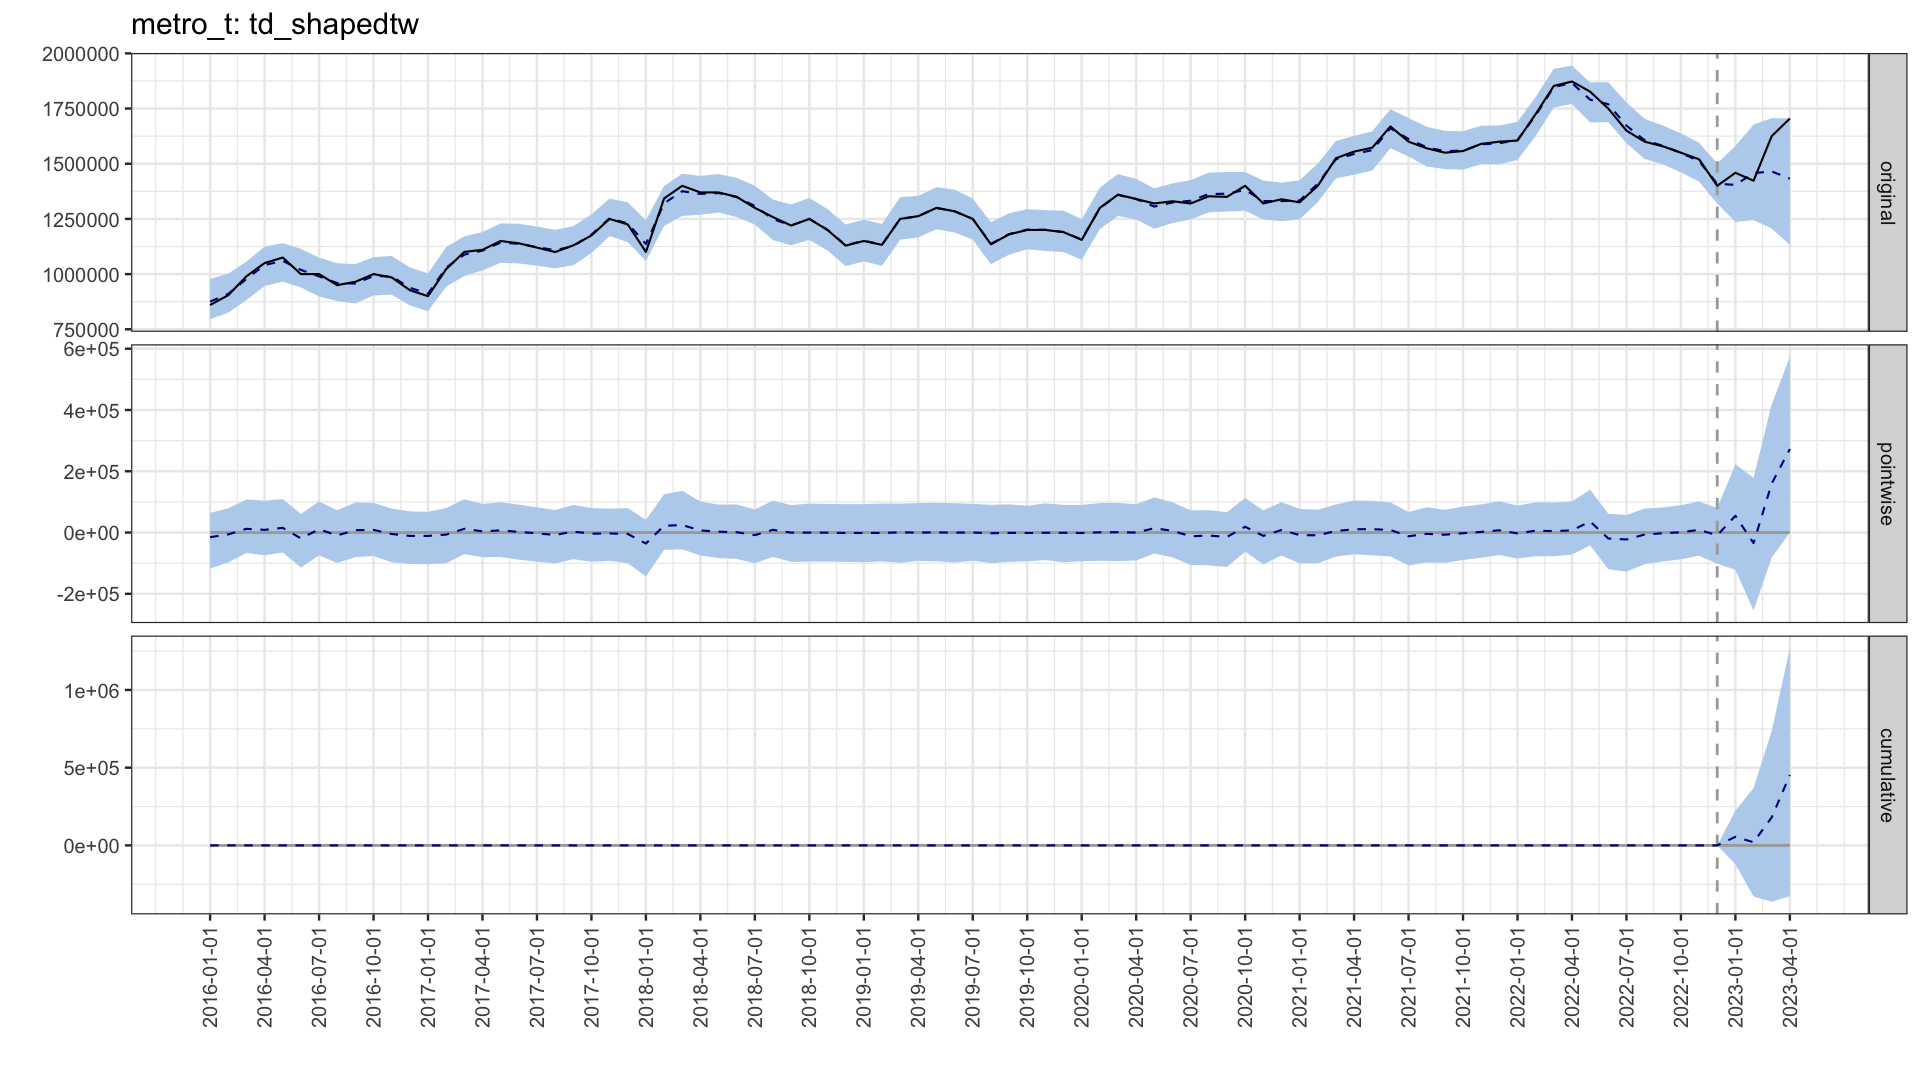

In [21]:
causal_SanJose <- CausalImpactModel(metro_name = "San Jose, CA metro area")

#### 5.2 Austin, TX

Time difference of 49.12 secs
# ----- dtw -----
Posterior inference {CausalImpact}

                         Average            Cumulative        
Actual                   454000             1816000           
Prediction (s.d.)        467368 (13359)     1869474 (53435)   
95% CI                   [440906, 494771]   [1763625, 1979083]
                                                              
Absolute effect (s.d.)   -13368 (13359)     -53474 (53435)    
95% CI                   [-40771, 13094]    [-163083, 52375]  
                                                              
Relative effect (s.d.)   -2.9% (2.9%)       -2.9% (2.9%)      
95% CI                   [-8.7%, 2.8%]      [-8.7%, 2.8%]     

Posterior tail-area probability p:   0.15017
Posterior prob. of a causal effect:  85%

For more details, type: summary(impact, "report")



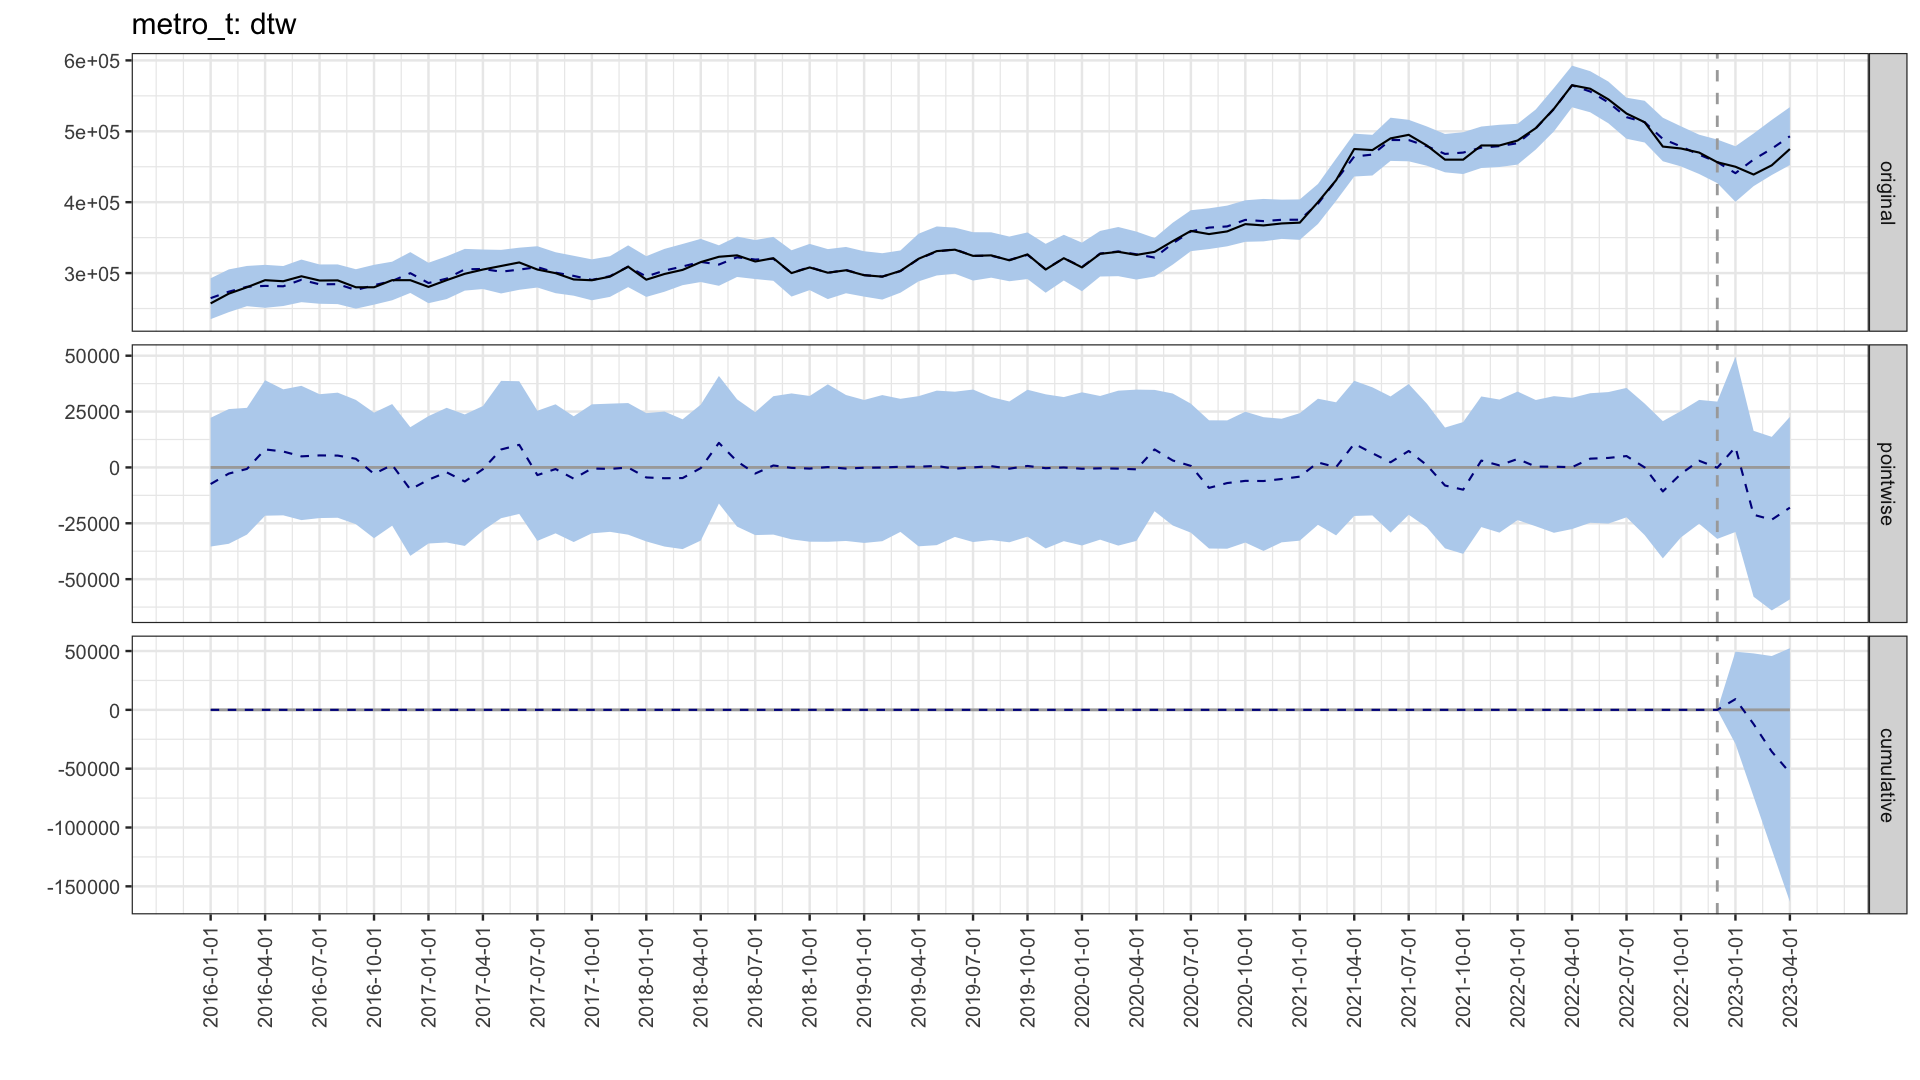

# ----- wdtw -----
Posterior inference {CausalImpact}

                         Average           Cumulative       
Actual                   454000            1816000          
Prediction (s.d.)        453191 (23381)    1812764 (93525)  
95% CI                   [405774, 5e+05]   [1623096, 2e+06] 
                                                            
Absolute effect (s.d.)   809 (23381)       3236 (93525)     
95% CI                   [-44593, 48226]   [-178372, 192904]
                                                            
Relative effect (s.d.)   0.18% (5.2%)      0.18% (5.2%)     
95% CI                   [-9.8%, 11%]      [-9.8%, 11%]     

Posterior tail-area probability p:   0.47427
Posterior prob. of a causal effect:  53%

For more details, type: summary(impact, "report")



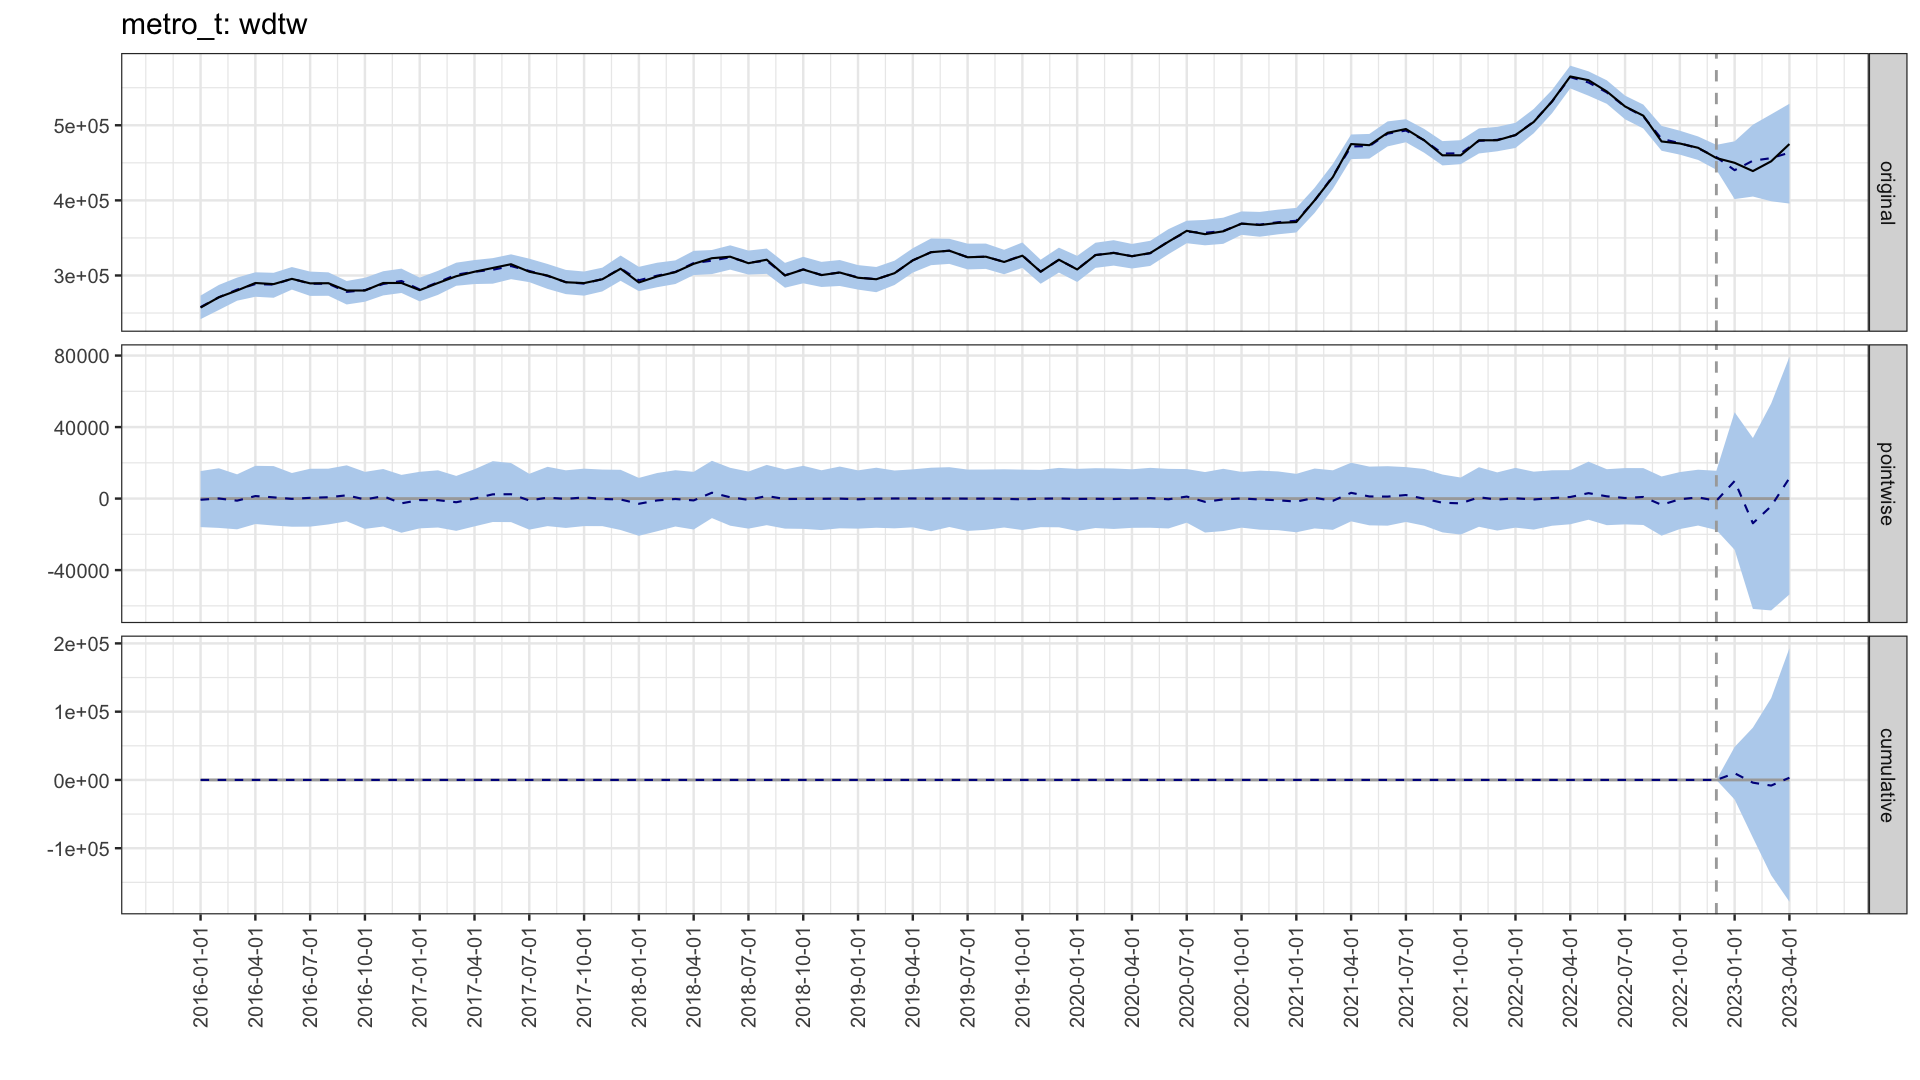

# ----- td_wdtw -----
Posterior inference {CausalImpact}

                         Average            Cumulative        
Actual                   454000             1816000           
Prediction (s.d.)        423682 (37178)     1694730 (148714)  
95% CI                   [347473, 492544]   [1389893, 1970177]
                                                              
Absolute effect (s.d.)   30318 (37178)      121270 (148714)   
95% CI                   [-38544, 106527]   [-154177, 426107] 
                                                              
Relative effect (s.d.)   7.2% (8.8%)        7.2% (8.8%)       
95% CI                   [-9.1%, 25%]       [-9.1%, 25%]      

Posterior tail-area probability p:   0.20527
Posterior prob. of a causal effect:  79%

For more details, type: summary(impact, "report")



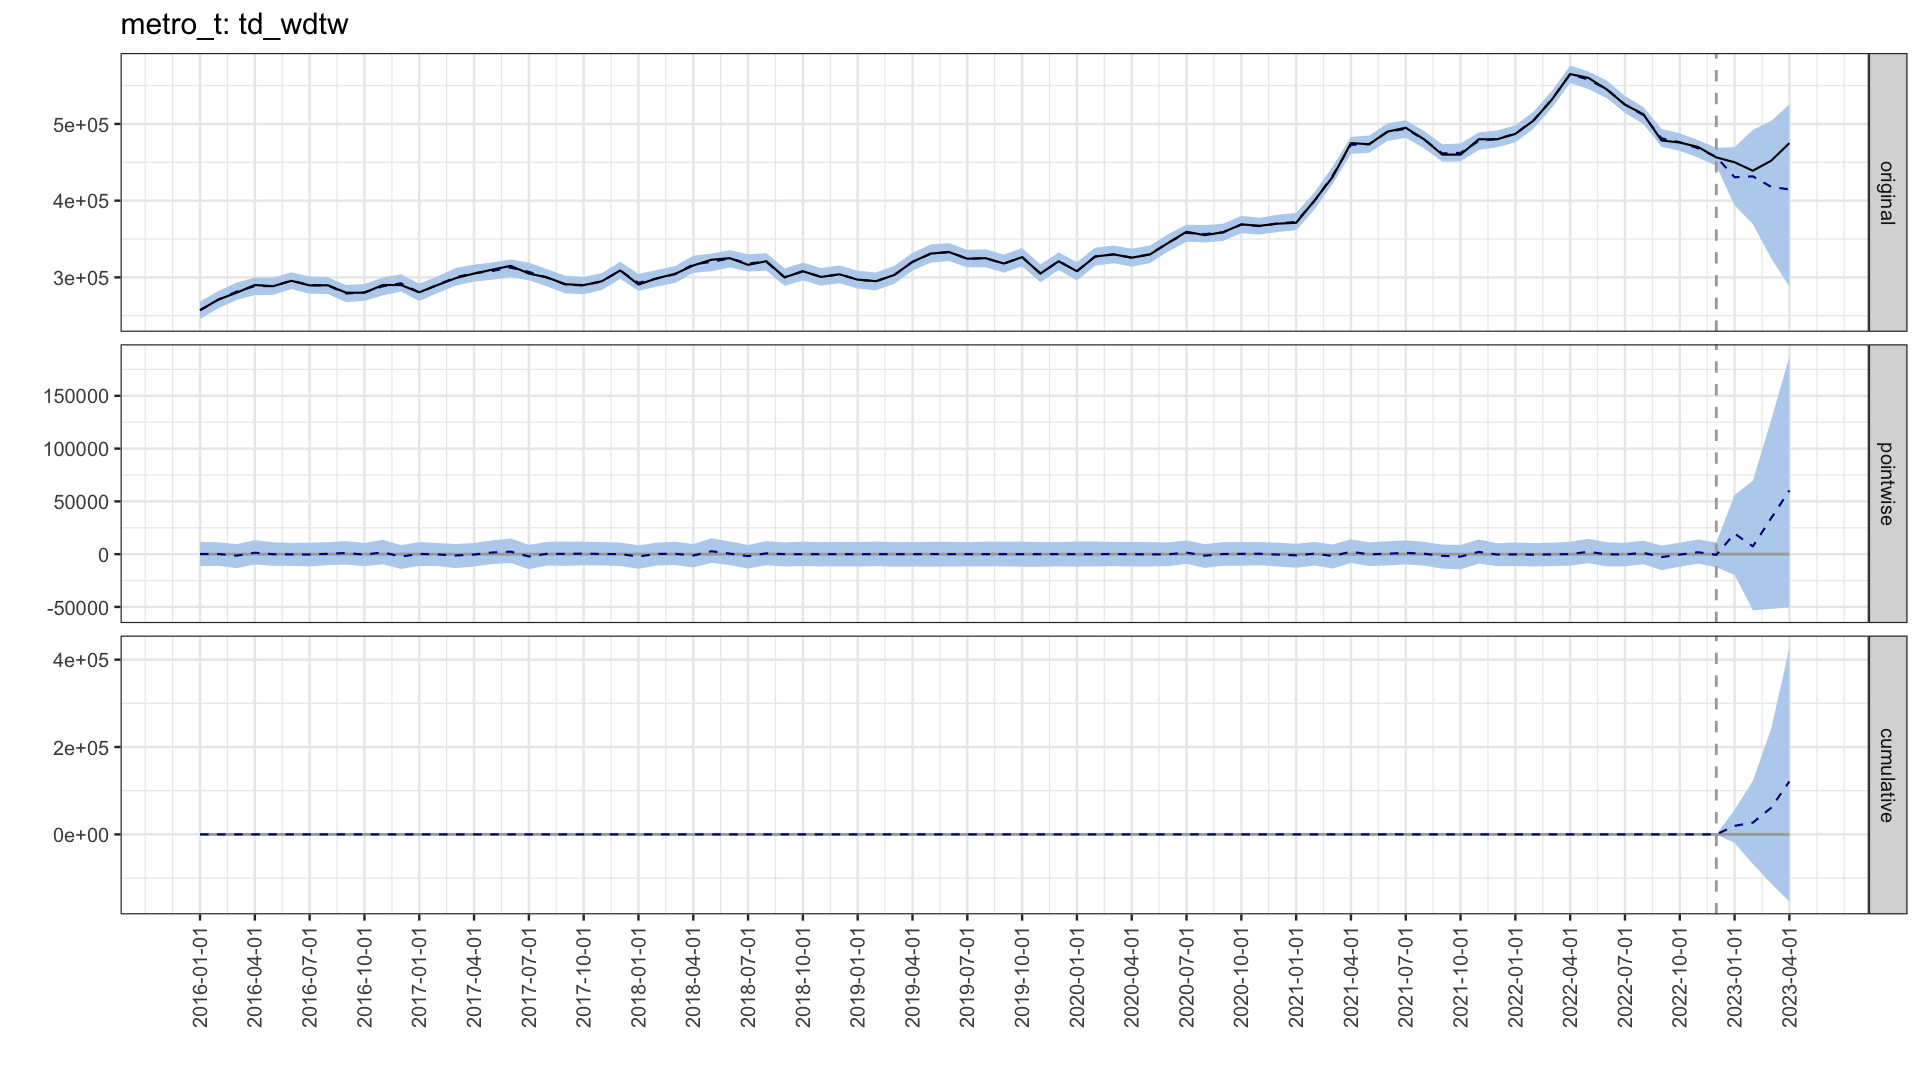

# ----- shapedtw -----
Posterior inference {CausalImpact}

                         Average            Cumulative        
Actual                   454000             1816000           
Prediction (s.d.)        456541 (15658)     1826164 (62632)   
95% CI                   [424688, 485553]   [1698751, 1942210]
                                                              
Absolute effect (s.d.)   -2541 (15658)      -10164 (62632)    
95% CI                   [-31553, 29312]    [-126210, 117249] 
                                                              
Relative effect (s.d.)   -0.56% (3.4%)      -0.56% (3.4%)     
95% CI                   [-6.9%, 6.4%]      [-6.9%, 6.4%]     

Posterior tail-area probability p:   0.422
Posterior prob. of a causal effect:  58%

For more details, type: summary(impact, "report")



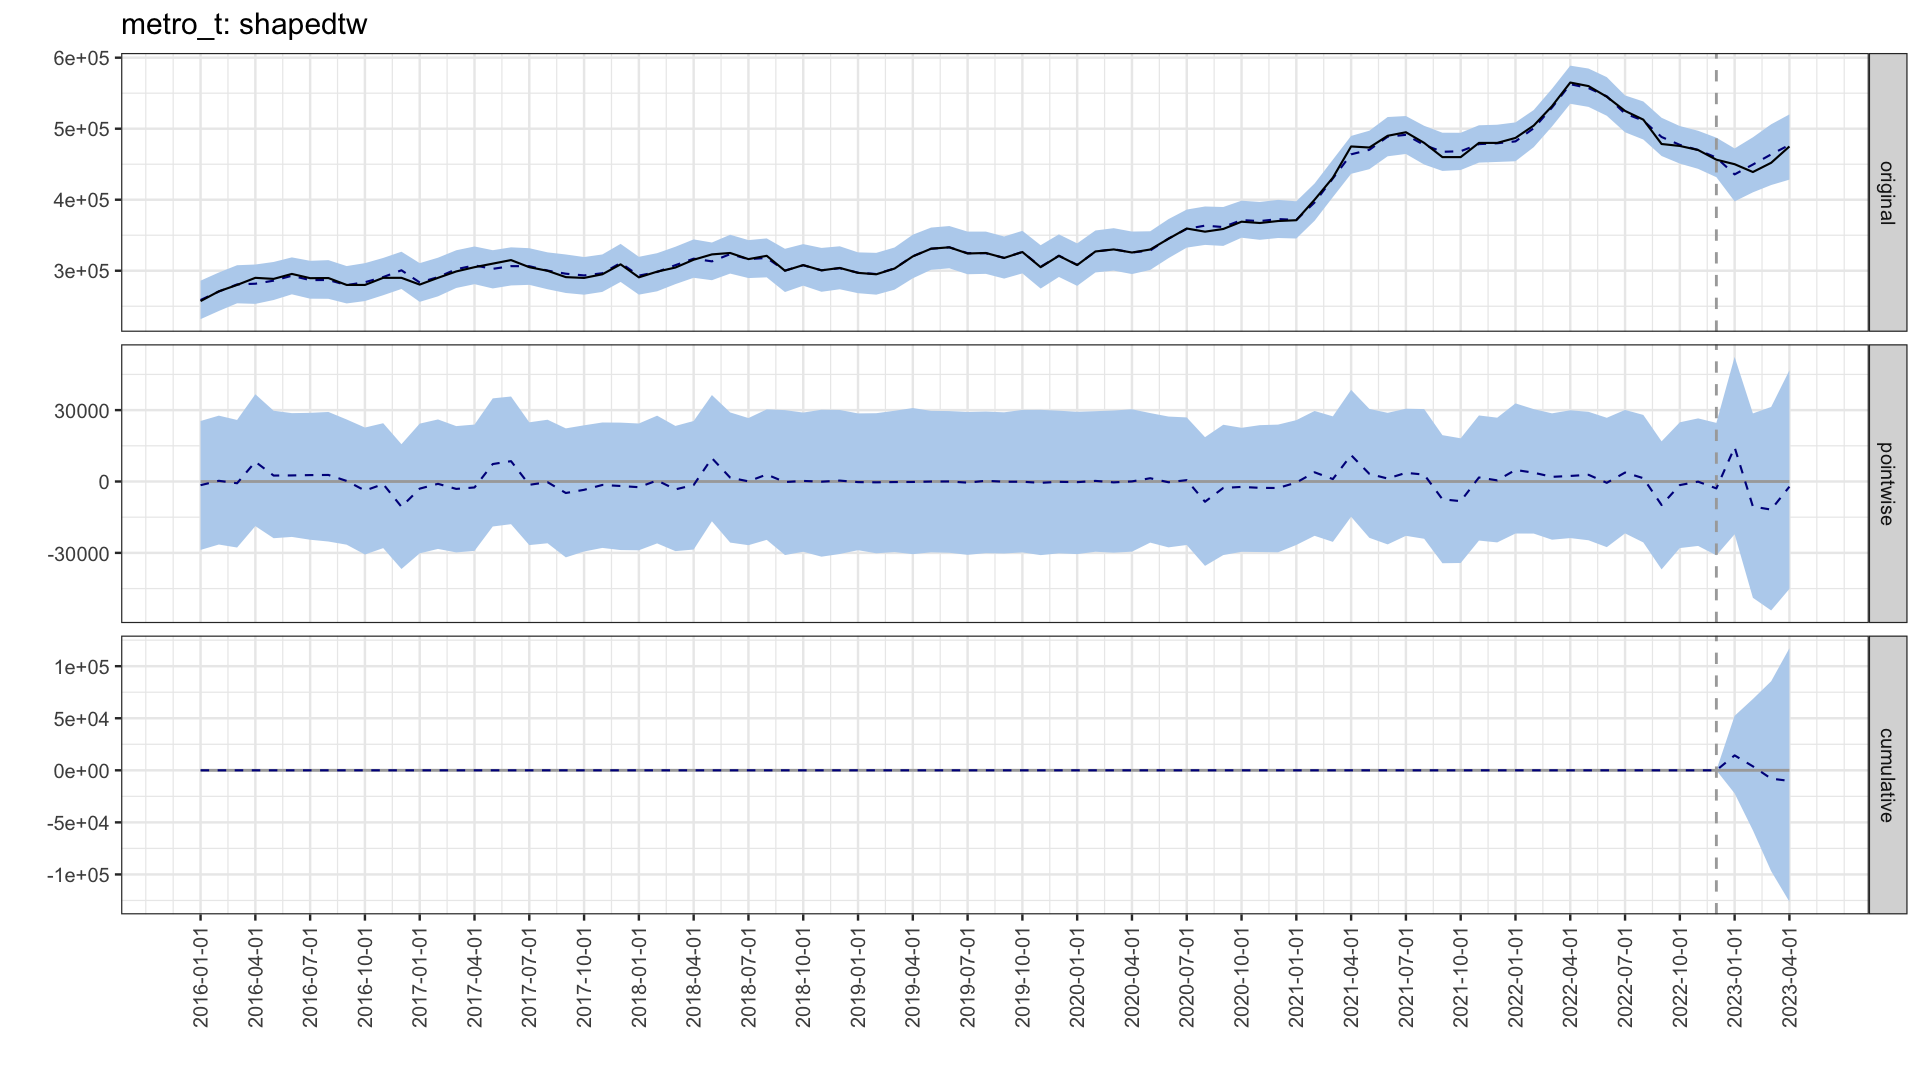

# ----- td_shapedtw -----
Posterior inference {CausalImpact}

                         Average            Cumulative        
Actual                   454000             1816000           
Prediction (s.d.)        459383 (16131)     1837530 (64524)   
95% CI                   [426984, 491500]   [1707935, 1966002]
                                                              
Absolute effect (s.d.)   -5383 (16131)      -21530 (64524)    
95% CI                   [-37500, 27016]    [-150002, 108065] 
                                                              
Relative effect (s.d.)   -1.2% (3.5%)       -1.2% (3.5%)      
95% CI                   [-8.2%, 5.9%]      [-8.2%, 5.9%]     

Posterior tail-area probability p:   0.35883
Posterior prob. of a causal effect:  64%

For more details, type: summary(impact, "report")



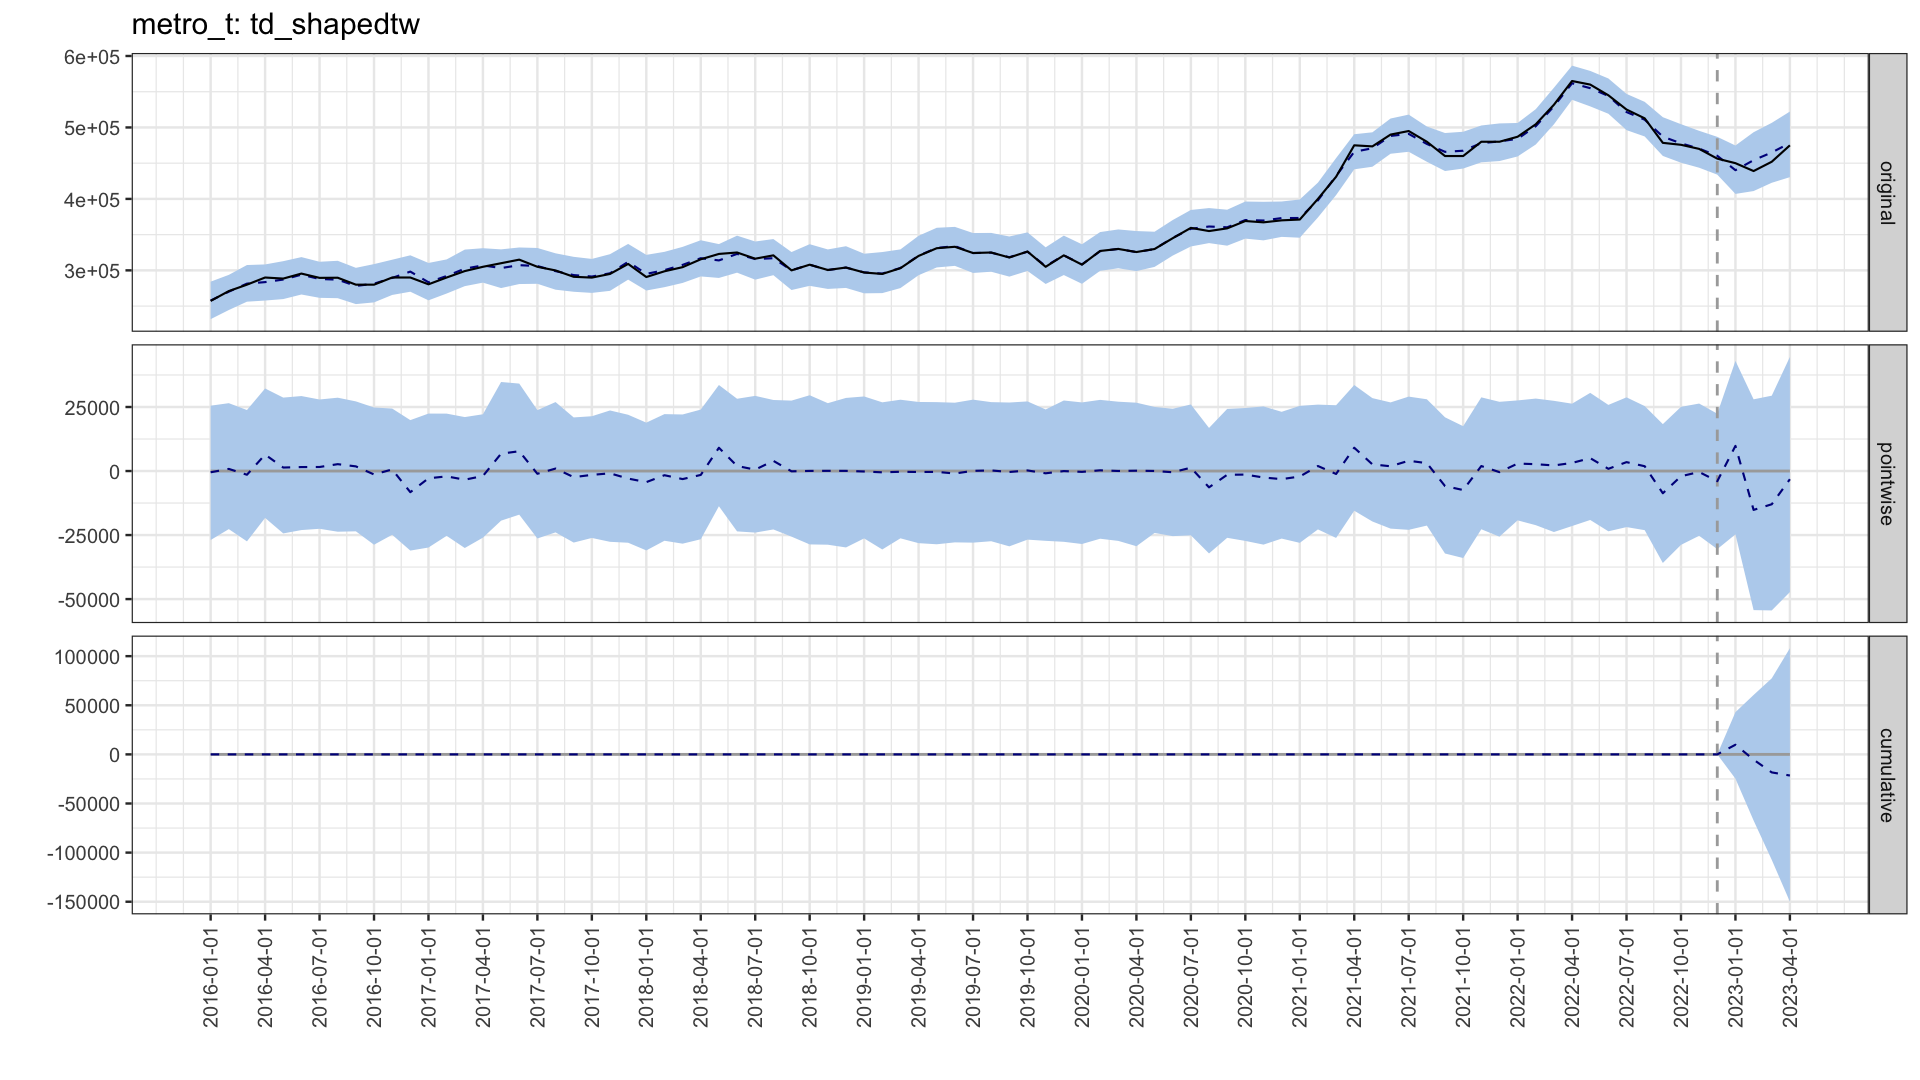

In [22]:
causal_Austin <- CausalImpactModel(metro_name = "Austin, TX metro area")

### Prediction Exercise

BSTS:

1. Use **DTW, WDTW, TD-WDTW, ShapeDTW, and TD-ShapeDTW** to find the top 10 or 20 matching results with data from 2016-01-01 to 2022-12-01 (6-year montly data), respectively

2. **Train 5 BSTS models** using the top 10 or 20 matching results from different methods

3. **Predict the price trend** in the first four months in 2023 based on the trained BSTS models

ML model (XGBoost, LSTM, Gated RNN):

+ stock market data (prediction purpose: US ~ UK, Singapore, Hongkong, Japan, France/Germany)

+ semi-conduct industry

References:

+ https://otexts.com/fpp3/advanced.htmlhttps://otexts.com/fpp3/advanced.html